In [5]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
import corner
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport plotting
%aimport keras_objects
from data_processing import *
from plotting import *
from keras_objects import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
model = load_model()

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [ ]:
mode = 'test' # 'train', 'val, 'test'

In [ ]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
predicted_points = predict_points(model, training_data_dict, data_type = mode)
title = 'Inputs: %s\n%.1e train points, test mse %.3e, %s data' % (', '.join(input_features), train_size, tot_score, mode)

In [ ]:
### Standard plots
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode,
                                   predicted_points = predicted_points)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig3 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Halo_mass', 
                                    y_axis_feature = 'Stellar_mass', title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig5 = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
                                    y_axis_feature = 'SFR', title=title, y_max = 5, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [ ]:
### Save the figures
date_string = datetime.datetime.now().strftime('%H-%M_%Y-%m-%d')
fig1.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Set model parameters

In [11]:
### General parameters
nr_steps = 5e3
nr_repetitions = 5
batch_size = 2e3
total_set_size = 6e4 # how many examples will be used for training+validation+testing
train_size = 1e4
val_size = 25e3
test_size = 25e3
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_half_mass', 'Scale_peak_mass', 'Redshift']
output_features = ['Stellar_mass', 'SFR']

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = int(nr_epochs / 10)
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nLayers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neuronsPerLayer = 10
reg_strength = 0#1e-5


## Load data

In [12]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=[0,1,2,5,10,20,30,40,60,80], equal_numbers=False)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
#galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [13]:
# Create model
main_input = Input(shape=(len(input_features),), name = 'main_input')

x1 = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength), 
          activation=activation_function)(main_input)
x2 = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength), 
          activation=activation_function)(main_input)
for i in range(0, nLayers-2): # -1 because one layer is added automatically with the input layer
    x1 = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength), 
              activation=activation_function)(x1)
    x2 = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength), 
              activation=activation_function)(x2)
    #x = LeakyReLU(alpha = 0.1)(x)
        
output_layers = []
output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), name = 'Stellar_mass',
                          activation = output_activation['Stellar_mass'])(x1))
output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), name = 'SFR',
                          activation = output_activation['SFR'])(x2))

model = Model(main_input, output_layers)
model.compile(optimizer = 'adam', loss = 'mse')

## Train model

In [17]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
#file_path = models_path + "model_checkpoint.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True, mode='min', period=10)
#callbacks_list = [earlystop, checkpoint]
callbacks_list = [earlystop]

train_weights, val_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                         weigh_by_redshift=weigh_by_redshift)

1237.6752000000001
3102.35528


Train on 10000 samples, validate on 25000 samples
Epoch 1/1000
10000/10000 [==============================] - 2s 159us/step - loss: 0.0127 - Stellar_mass_loss: 0.0123 - SFR_loss: 3.9389e-04 - val_loss: 0.0047 - val_Stellar_mass_loss: 0.0046 - val_SFR_loss: 1.4597e-04
Epoch 2/1000
10000/10000 [==============================] - 0s 21us/step - loss: 0.0123 - Stellar_mass_loss: 0.0119 - SFR_loss: 3.4036e-04 - val_loss: 0.0045 - val_Stellar_mass_loss: 0.0044 - val_SFR_loss: 1.2587e-04
Epoch 3/1000
10000/10000 [==============================] - 0s 19us/step - loss: 0.0117 - Stellar_mass_loss: 0.0115 - SFR_loss: 2.9094e-04 - val_loss: 0.0044 - val_Stellar_mass_loss: 0.0042 - val_SFR_loss: 1.0585e-04
Epoch 4/1000
10000/10000 [==============================] - 0s 19us/step - loss: 0.0113 - Stellar_mass_loss: 0.0110 - SFR_loss: 2.3995e-04 - val_loss: 0.0042 - val_Stellar_mass_loss: 0.0041 - val_SFR_loss: 8.4611e-05
Epoch 5/1000
10000/10000 [==============================] - 0s 20us/step - loss: 

10000/10000 [==============================] - 0s 20us/step - loss: 0.0025 - Stellar_mass_loss: 0.0024 - SFR_loss: 2.3546e-05 - val_loss: 8.6117e-04 - val_Stellar_mass_loss: 8.5140e-04 - val_SFR_loss: 9.7783e-06
Epoch 76/1000
10000/10000 [==============================] - 0s 20us/step - loss: 0.0024 - Stellar_mass_loss: 0.0024 - SFR_loss: 2.3429e-05 - val_loss: 8.4712e-04 - val_Stellar_mass_loss: 8.3740e-04 - val_SFR_loss: 9.7162e-06
Epoch 77/1000
10000/10000 [==============================] - 0s 20us/step - loss: 0.0024 - Stellar_mass_loss: 0.0024 - SFR_loss: 2.3262e-05 - val_loss: 8.3173e-04 - val_Stellar_mass_loss: 8.2207e-04 - val_SFR_loss: 9.6655e-06
Epoch 78/1000
10000/10000 [==============================] - 0s 19us/step - loss: 0.0023 - Stellar_mass_loss: 0.0023 - SFR_loss: 2.3132e-05 - val_loss: 8.1734e-04 - val_Stellar_mass_loss: 8.0773e-04 - val_SFR_loss: 9.6086e-06
Epoch 79/1000
10000/10000 [==============================] - 0s 18us/step - loss: 0.0023 - Stellar_mass_loss: 

10000/10000 [==============================] - 0s 20us/step - loss: 7.1256e-04 - Stellar_mass_loss: 6.9295e-04 - SFR_loss: 1.9613e-05 - val_loss: 2.2934e-04 - val_Stellar_mass_loss: 2.2114e-04 - val_SFR_loss: 8.1932e-06
Epoch 147/1000
10000/10000 [==============================] - 0s 19us/step - loss: 6.9874e-04 - Stellar_mass_loss: 6.7920e-04 - SFR_loss: 1.9543e-05 - val_loss: 2.2515e-04 - val_Stellar_mass_loss: 2.1697e-04 - val_SFR_loss: 8.1810e-06
Epoch 148/1000
10000/10000 [==============================] - 0s 20us/step - loss: 6.8837e-04 - Stellar_mass_loss: 6.6888e-04 - SFR_loss: 1.9486e-05 - val_loss: 2.2075e-04 - val_Stellar_mass_loss: 2.1257e-04 - val_SFR_loss: 8.1771e-06
Epoch 149/1000
10000/10000 [==============================] - 0s 19us/step - loss: 6.7362e-04 - Stellar_mass_loss: 6.5415e-04 - SFR_loss: 1.9471e-05 - val_loss: 2.1688e-04 - val_Stellar_mass_loss: 2.0870e-04 - val_SFR_loss: 8.1808e-06
Epoch 150/1000
10000/10000 [==============================] - 0s 19us/step 

Epoch 181/1000
10000/10000 [==============================] - 0s 19us/step - loss: 3.8941e-04 - Stellar_mass_loss: 3.7084e-04 - SFR_loss: 1.8575e-05 - val_loss: 1.2248e-04 - val_Stellar_mass_loss: 1.1465e-04 - val_SFR_loss: 7.8271e-06
Epoch 182/1000
10000/10000 [==============================] - 0s 21us/step - loss: 3.8343e-04 - Stellar_mass_loss: 3.6484e-04 - SFR_loss: 1.8585e-05 - val_loss: 1.2049e-04 - val_Stellar_mass_loss: 1.1268e-04 - val_SFR_loss: 7.8114e-06
Epoch 183/1000
10000/10000 [==============================] - 0s 19us/step - loss: 3.7730e-04 - Stellar_mass_loss: 3.5877e-04 - SFR_loss: 1.8533e-05 - val_loss: 1.1855e-04 - val_Stellar_mass_loss: 1.1075e-04 - val_SFR_loss: 7.7944e-06
Epoch 184/1000
10000/10000 [==============================] - 0s 20us/step - loss: 3.7114e-04 - Stellar_mass_loss: 3.5265e-04 - SFR_loss: 1.8493e-05 - val_loss: 1.1668e-04 - val_Stellar_mass_loss: 1.0889e-04 - val_SFR_loss: 7.7910e-06
Epoch 185/1000
10000/10000 [==============================] 

Epoch 216/1000
10000/10000 [==============================] - 0s 19us/step - loss: 2.3556e-04 - Stellar_mass_loss: 2.1765e-04 - SFR_loss: 1.7905e-05 - val_loss: 7.6314e-05 - val_Stellar_mass_loss: 6.8690e-05 - val_SFR_loss: 7.6240e-06
Epoch 217/1000
10000/10000 [==============================] - 0s 20us/step - loss: 2.3247e-04 - Stellar_mass_loss: 2.1454e-04 - SFR_loss: 1.7927e-05 - val_loss: 7.5489e-05 - val_Stellar_mass_loss: 6.7945e-05 - val_SFR_loss: 7.5438e-06
Epoch 218/1000
10000/10000 [==============================] - 0s 19us/step - loss: 2.2941e-04 - Stellar_mass_loss: 2.1149e-04 - SFR_loss: 1.7919e-05 - val_loss: 7.4820e-05 - val_Stellar_mass_loss: 6.7268e-05 - val_SFR_loss: 7.5522e-06
Epoch 219/1000
10000/10000 [==============================] - 0s 18us/step - loss: 2.2695e-04 - Stellar_mass_loss: 2.0904e-04 - SFR_loss: 1.7904e-05 - val_loss: 7.4148e-05 - val_Stellar_mass_loss: 6.6577e-05 - val_SFR_loss: 7.5710e-06
Epoch 220/1000
10000/10000 [==============================] 

Epoch 251/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6906e-04 - Stellar_mass_loss: 1.5168e-04 - SFR_loss: 1.7385e-05 - val_loss: 6.0473e-05 - val_Stellar_mass_loss: 5.3095e-05 - val_SFR_loss: 7.3782e-06
Epoch 252/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.6807e-04 - Stellar_mass_loss: 1.5070e-04 - SFR_loss: 1.7363e-05 - val_loss: 6.0187e-05 - val_Stellar_mass_loss: 5.2873e-05 - val_SFR_loss: 7.3140e-06
Epoch 253/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6671e-04 - Stellar_mass_loss: 1.4934e-04 - SFR_loss: 1.7371e-05 - val_loss: 6.0056e-05 - val_Stellar_mass_loss: 5.2684e-05 - val_SFR_loss: 7.3729e-06
Epoch 254/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.6587e-04 - Stellar_mass_loss: 1.4854e-04 - SFR_loss: 1.7333e-05 - val_loss: 5.9773e-05 - val_Stellar_mass_loss: 5.2483e-05 - val_SFR_loss: 7.2900e-06
Epoch 255/1000
10000/10000 [==============================] 

Epoch 286/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4362e-04 - Stellar_mass_loss: 1.2666e-04 - SFR_loss: 1.6957e-05 - val_loss: 5.7173e-05 - val_Stellar_mass_loss: 4.9955e-05 - val_SFR_loss: 7.2185e-06
Epoch 287/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4328e-04 - Stellar_mass_loss: 1.2628e-04 - SFR_loss: 1.7000e-05 - val_loss: 5.7098e-05 - val_Stellar_mass_loss: 4.9947e-05 - val_SFR_loss: 7.1510e-06
Epoch 288/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4284e-04 - Stellar_mass_loss: 1.2589e-04 - SFR_loss: 1.6951e-05 - val_loss: 5.7096e-05 - val_Stellar_mass_loss: 4.9941e-05 - val_SFR_loss: 7.1558e-06
Epoch 289/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4262e-04 - Stellar_mass_loss: 1.2568e-04 - SFR_loss: 1.6937e-05 - val_loss: 5.7062e-05 - val_Stellar_mass_loss: 4.9936e-05 - val_SFR_loss: 7.1257e-06
Epoch 290/1000
10000/10000 [==============================] 

Epoch 321/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3495e-04 - Stellar_mass_loss: 1.1827e-04 - SFR_loss: 1.6675e-05 - val_loss: 5.7682e-05 - val_Stellar_mass_loss: 5.0629e-05 - val_SFR_loss: 7.0532e-06
Epoch 322/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3473e-04 - Stellar_mass_loss: 1.1808e-04 - SFR_loss: 1.6653e-05 - val_loss: 5.7752e-05 - val_Stellar_mass_loss: 5.0683e-05 - val_SFR_loss: 7.0694e-06
Epoch 323/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3457e-04 - Stellar_mass_loss: 1.1790e-04 - SFR_loss: 1.6671e-05 - val_loss: 5.7749e-05 - val_Stellar_mass_loss: 5.0706e-05 - val_SFR_loss: 7.0427e-06
Epoch 324/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3450e-04 - Stellar_mass_loss: 1.1785e-04 - SFR_loss: 1.6655e-05 - val_loss: 5.7788e-05 - val_Stellar_mass_loss: 5.0728e-05 - val_SFR_loss: 7.0598e-06
Epoch 325/1000
10000/10000 [==============================] 

Epoch 356/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2914e-04 - Stellar_mass_loss: 1.1286e-04 - SFR_loss: 1.6275e-05 - val_loss: 5.7098e-05 - val_Stellar_mass_loss: 5.0220e-05 - val_SFR_loss: 6.8787e-06
Epoch 357/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2883e-04 - Stellar_mass_loss: 1.1257e-04 - SFR_loss: 1.6258e-05 - val_loss: 5.6923e-05 - val_Stellar_mass_loss: 5.0038e-05 - val_SFR_loss: 6.8852e-06
Epoch 358/1000
10000/10000 [==============================] - 0s 22us/step - loss: 1.2842e-04 - Stellar_mass_loss: 1.1216e-04 - SFR_loss: 1.6260e-05 - val_loss: 5.6760e-05 - val_Stellar_mass_loss: 4.9895e-05 - val_SFR_loss: 6.8649e-06
Epoch 359/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2810e-04 - Stellar_mass_loss: 1.1181e-04 - SFR_loss: 1.6291e-05 - val_loss: 5.6544e-05 - val_Stellar_mass_loss: 4.9638e-05 - val_SFR_loss: 6.9059e-06
Epoch 360/1000
10000/10000 [==============================] 

Epoch 391/1000
10000/10000 [==============================] - 0s 20us/step - loss: 6.7112e-05 - Stellar_mass_loss: 5.1116e-05 - SFR_loss: 1.5996e-05 - val_loss: 2.4402e-05 - val_Stellar_mass_loss: 1.7657e-05 - val_SFR_loss: 6.7451e-06
Epoch 392/1000
10000/10000 [==============================] - 0s 20us/step - loss: 6.5759e-05 - Stellar_mass_loss: 4.9680e-05 - SFR_loss: 1.6080e-05 - val_loss: 2.3754e-05 - val_Stellar_mass_loss: 1.6962e-05 - val_SFR_loss: 6.7916e-06
Epoch 393/1000
10000/10000 [==============================] - 0s 20us/step - loss: 6.4121e-05 - Stellar_mass_loss: 4.8129e-05 - SFR_loss: 1.5992e-05 - val_loss: 2.3121e-05 - val_Stellar_mass_loss: 1.6300e-05 - val_SFR_loss: 6.8205e-06
Epoch 394/1000
10000/10000 [==============================] - 0s 20us/step - loss: 6.2707e-05 - Stellar_mass_loss: 4.6698e-05 - SFR_loss: 1.6009e-05 - val_loss: 2.2399e-05 - val_Stellar_mass_loss: 1.5634e-05 - val_SFR_loss: 6.7650e-06
Epoch 395/1000
10000/10000 [==============================] 

Epoch 426/1000
10000/10000 [==============================] - 0s 19us/step - loss: 3.1496e-05 - Stellar_mass_loss: 1.5886e-05 - SFR_loss: 1.5610e-05 - val_loss: 9.7019e-06 - val_Stellar_mass_loss: 3.0508e-06 - val_SFR_loss: 6.6511e-06
Epoch 427/1000
10000/10000 [==============================] - 0s 20us/step - loss: 3.1084e-05 - Stellar_mass_loss: 1.5479e-05 - SFR_loss: 1.5605e-05 - val_loss: 9.5847e-06 - val_Stellar_mass_loss: 2.9904e-06 - val_SFR_loss: 6.5943e-06
Epoch 428/1000
10000/10000 [==============================] - 0s 20us/step - loss: 3.0771e-05 - Stellar_mass_loss: 1.5222e-05 - SFR_loss: 1.5549e-05 - val_loss: 9.4990e-06 - val_Stellar_mass_loss: 2.9238e-06 - val_SFR_loss: 6.5751e-06
Epoch 429/1000
10000/10000 [==============================] - 0s 19us/step - loss: 3.0451e-05 - Stellar_mass_loss: 1.4919e-05 - SFR_loss: 1.5532e-05 - val_loss: 9.4347e-06 - val_Stellar_mass_loss: 2.8617e-06 - val_SFR_loss: 6.5731e-06
Epoch 430/1000
10000/10000 [==============================] 

Epoch 461/1000
10000/10000 [==============================] - 0s 19us/step - loss: 2.3636e-05 - Stellar_mass_loss: 8.3816e-06 - SFR_loss: 1.5254e-05 - val_loss: 8.0291e-06 - val_Stellar_mass_loss: 1.5612e-06 - val_SFR_loss: 6.4680e-06
Epoch 462/1000
10000/10000 [==============================] - 0s 19us/step - loss: 2.3470e-05 - Stellar_mass_loss: 8.2437e-06 - SFR_loss: 1.5226e-05 - val_loss: 8.0558e-06 - val_Stellar_mass_loss: 1.5374e-06 - val_SFR_loss: 6.5184e-06
Epoch 463/1000
10000/10000 [==============================] - 0s 18us/step - loss: 2.3488e-05 - Stellar_mass_loss: 8.1799e-06 - SFR_loss: 1.5308e-05 - val_loss: 8.0641e-06 - val_Stellar_mass_loss: 1.5112e-06 - val_SFR_loss: 6.5529e-06
Epoch 464/1000
10000/10000 [==============================] - 0s 20us/step - loss: 2.3249e-05 - Stellar_mass_loss: 8.0131e-06 - SFR_loss: 1.5236e-05 - val_loss: 7.9259e-06 - val_Stellar_mass_loss: 1.4890e-06 - val_SFR_loss: 6.4368e-06
Epoch 465/1000
10000/10000 [==============================] 

Epoch 496/1000
10000/10000 [==============================] - 0s 20us/step - loss: 2.0266e-05 - Stellar_mass_loss: 5.2396e-06 - SFR_loss: 1.5027e-05 - val_loss: 7.3988e-06 - val_Stellar_mass_loss: 9.8081e-07 - val_SFR_loss: 6.4180e-06
Epoch 497/1000
10000/10000 [==============================] - 0s 20us/step - loss: 2.0223e-05 - Stellar_mass_loss: 5.1640e-06 - SFR_loss: 1.5059e-05 - val_loss: 7.3654e-06 - val_Stellar_mass_loss: 9.6987e-07 - val_SFR_loss: 6.3955e-06
Epoch 498/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.9959e-05 - Stellar_mass_loss: 5.1012e-06 - SFR_loss: 1.4858e-05 - val_loss: 7.3446e-06 - val_Stellar_mass_loss: 9.6140e-07 - val_SFR_loss: 6.3832e-06
Epoch 499/1000
10000/10000 [==============================] - 0s 20us/step - loss: 2.0012e-05 - Stellar_mass_loss: 5.0635e-06 - SFR_loss: 1.4949e-05 - val_loss: 7.3446e-06 - val_Stellar_mass_loss: 9.5726e-07 - val_SFR_loss: 6.3874e-06
Epoch 500/1000
10000/10000 [==============================] 

Epoch 531/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.8432e-05 - Stellar_mass_loss: 3.7532e-06 - SFR_loss: 1.4679e-05 - val_loss: 7.0217e-06 - val_Stellar_mass_loss: 7.4282e-07 - val_SFR_loss: 6.2788e-06
Epoch 532/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.8392e-05 - Stellar_mass_loss: 3.6991e-06 - SFR_loss: 1.4693e-05 - val_loss: 7.0041e-06 - val_Stellar_mass_loss: 7.3401e-07 - val_SFR_loss: 6.2701e-06
Epoch 533/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.8348e-05 - Stellar_mass_loss: 3.6819e-06 - SFR_loss: 1.4666e-05 - val_loss: 6.9890e-06 - val_Stellar_mass_loss: 7.2371e-07 - val_SFR_loss: 6.2653e-06
Epoch 534/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.8335e-05 - Stellar_mass_loss: 3.6539e-06 - SFR_loss: 1.4681e-05 - val_loss: 7.0110e-06 - val_Stellar_mass_loss: 7.3390e-07 - val_SFR_loss: 6.2771e-06
Epoch 535/1000
10000/10000 [==============================] 

Epoch 566/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.7397e-05 - Stellar_mass_loss: 2.8946e-06 - SFR_loss: 1.4502e-05 - val_loss: 6.8249e-06 - val_Stellar_mass_loss: 6.1754e-07 - val_SFR_loss: 6.2074e-06
Epoch 567/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.7409e-05 - Stellar_mass_loss: 2.8714e-06 - SFR_loss: 1.4537e-05 - val_loss: 6.8411e-06 - val_Stellar_mass_loss: 6.2037e-07 - val_SFR_loss: 6.2207e-06
Epoch 568/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.7397e-05 - Stellar_mass_loss: 2.8711e-06 - SFR_loss: 1.4526e-05 - val_loss: 6.8136e-06 - val_Stellar_mass_loss: 6.0201e-07 - val_SFR_loss: 6.2116e-06
Epoch 569/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.7302e-05 - Stellar_mass_loss: 2.8393e-06 - SFR_loss: 1.4462e-05 - val_loss: 6.8028e-06 - val_Stellar_mass_loss: 6.0477e-07 - val_SFR_loss: 6.1980e-06
Epoch 570/1000
10000/10000 [==============================] 

Epoch 601/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6755e-05 - Stellar_mass_loss: 2.4292e-06 - SFR_loss: 1.4326e-05 - val_loss: 6.7191e-06 - val_Stellar_mass_loss: 5.7008e-07 - val_SFR_loss: 6.1490e-06
Epoch 602/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6710e-05 - Stellar_mass_loss: 2.3733e-06 - SFR_loss: 1.4337e-05 - val_loss: 6.6941e-06 - val_Stellar_mass_loss: 5.4762e-07 - val_SFR_loss: 6.1464e-06
Epoch 603/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.6684e-05 - Stellar_mass_loss: 2.3619e-06 - SFR_loss: 1.4322e-05 - val_loss: 6.7009e-06 - val_Stellar_mass_loss: 5.5195e-07 - val_SFR_loss: 6.1489e-06
Epoch 604/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.6667e-05 - Stellar_mass_loss: 2.3479e-06 - SFR_loss: 1.4320e-05 - val_loss: 6.7300e-06 - val_Stellar_mass_loss: 5.5536e-07 - val_SFR_loss: 6.1747e-06
Epoch 605/1000
10000/10000 [==============================] 

Epoch 636/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6351e-05 - Stellar_mass_loss: 2.0600e-06 - SFR_loss: 1.4291e-05 - val_loss: 6.6683e-06 - val_Stellar_mass_loss: 5.4890e-07 - val_SFR_loss: 6.1194e-06
Epoch 637/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6495e-05 - Stellar_mass_loss: 2.1776e-06 - SFR_loss: 1.4317e-05 - val_loss: 6.7155e-06 - val_Stellar_mass_loss: 5.5122e-07 - val_SFR_loss: 6.1642e-06
Epoch 638/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.6473e-05 - Stellar_mass_loss: 2.1223e-06 - SFR_loss: 1.4350e-05 - val_loss: 6.6510e-06 - val_Stellar_mass_loss: 5.3200e-07 - val_SFR_loss: 6.1190e-06
Epoch 639/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6394e-05 - Stellar_mass_loss: 2.0821e-06 - SFR_loss: 1.4312e-05 - val_loss: 6.6844e-06 - val_Stellar_mass_loss: 5.7224e-07 - val_SFR_loss: 6.1122e-06
Epoch 640/1000
10000/10000 [==============================] 

Epoch 671/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6139e-05 - Stellar_mass_loss: 1.9249e-06 - SFR_loss: 1.4214e-05 - val_loss: 6.6849e-06 - val_Stellar_mass_loss: 5.5373e-07 - val_SFR_loss: 6.1312e-06
Epoch 672/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6137e-05 - Stellar_mass_loss: 1.8717e-06 - SFR_loss: 1.4265e-05 - val_loss: 6.6173e-06 - val_Stellar_mass_loss: 5.0135e-07 - val_SFR_loss: 6.1160e-06
Epoch 673/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.6060e-05 - Stellar_mass_loss: 1.8404e-06 - SFR_loss: 1.4219e-05 - val_loss: 6.6084e-06 - val_Stellar_mass_loss: 5.3083e-07 - val_SFR_loss: 6.0775e-06
Epoch 674/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.6060e-05 - Stellar_mass_loss: 1.9147e-06 - SFR_loss: 1.4145e-05 - val_loss: 6.6443e-06 - val_Stellar_mass_loss: 5.6406e-07 - val_SFR_loss: 6.0802e-06
Epoch 675/1000
10000/10000 [==============================] 

Epoch 706/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5899e-05 - Stellar_mass_loss: 1.8067e-06 - SFR_loss: 1.4092e-05 - val_loss: 6.5512e-06 - val_Stellar_mass_loss: 5.0108e-07 - val_SFR_loss: 6.0501e-06
Epoch 707/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5724e-05 - Stellar_mass_loss: 1.6774e-06 - SFR_loss: 1.4046e-05 - val_loss: 6.5622e-06 - val_Stellar_mass_loss: 5.2594e-07 - val_SFR_loss: 6.0363e-06
Epoch 708/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5808e-05 - Stellar_mass_loss: 1.6959e-06 - SFR_loss: 1.4112e-05 - val_loss: 6.5680e-06 - val_Stellar_mass_loss: 5.3595e-07 - val_SFR_loss: 6.0320e-06
Epoch 709/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.5998e-05 - Stellar_mass_loss: 1.9278e-06 - SFR_loss: 1.4070e-05 - val_loss: 6.5900e-06 - val_Stellar_mass_loss: 5.6360e-07 - val_SFR_loss: 6.0264e-06
Epoch 710/1000
10000/10000 [==============================] 

Epoch 741/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5567e-05 - Stellar_mass_loss: 1.5464e-06 - SFR_loss: 1.4021e-05 - val_loss: 6.5342e-06 - val_Stellar_mass_loss: 5.0833e-07 - val_SFR_loss: 6.0259e-06
Epoch 742/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.5551e-05 - Stellar_mass_loss: 1.5161e-06 - SFR_loss: 1.4035e-05 - val_loss: 6.5262e-06 - val_Stellar_mass_loss: 5.0154e-07 - val_SFR_loss: 6.0247e-06
Epoch 743/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5576e-05 - Stellar_mass_loss: 1.5530e-06 - SFR_loss: 1.4023e-05 - val_loss: 6.5530e-06 - val_Stellar_mass_loss: 5.2963e-07 - val_SFR_loss: 6.0234e-06
Epoch 744/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5651e-05 - Stellar_mass_loss: 1.5370e-06 - SFR_loss: 1.4114e-05 - val_loss: 6.5474e-06 - val_Stellar_mass_loss: 5.2681e-07 - val_SFR_loss: 6.0206e-06
Epoch 745/1000
10000/10000 [==============================] 

Epoch 776/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5449e-05 - Stellar_mass_loss: 1.4654e-06 - SFR_loss: 1.3984e-05 - val_loss: 6.4883e-06 - val_Stellar_mass_loss: 5.1494e-07 - val_SFR_loss: 5.9733e-06
Epoch 777/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5386e-05 - Stellar_mass_loss: 1.4318e-06 - SFR_loss: 1.3954e-05 - val_loss: 6.5272e-06 - val_Stellar_mass_loss: 5.4270e-07 - val_SFR_loss: 5.9845e-06
Epoch 778/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5491e-05 - Stellar_mass_loss: 1.5112e-06 - SFR_loss: 1.3980e-05 - val_loss: 6.4943e-06 - val_Stellar_mass_loss: 5.1891e-07 - val_SFR_loss: 5.9754e-06
Epoch 779/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5566e-05 - Stellar_mass_loss: 1.5054e-06 - SFR_loss: 1.4060e-05 - val_loss: 6.5004e-06 - val_Stellar_mass_loss: 4.9292e-07 - val_SFR_loss: 6.0075e-06
Epoch 780/1000
10000/10000 [==============================] 

Epoch 811/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5351e-05 - Stellar_mass_loss: 1.3560e-06 - SFR_loss: 1.3995e-05 - val_loss: 6.5235e-06 - val_Stellar_mass_loss: 4.9379e-07 - val_SFR_loss: 6.0297e-06
Epoch 812/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5399e-05 - Stellar_mass_loss: 1.3644e-06 - SFR_loss: 1.4035e-05 - val_loss: 6.4954e-06 - val_Stellar_mass_loss: 5.0909e-07 - val_SFR_loss: 5.9864e-06
Epoch 813/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5391e-05 - Stellar_mass_loss: 1.3556e-06 - SFR_loss: 1.4035e-05 - val_loss: 6.5240e-06 - val_Stellar_mass_loss: 5.1021e-07 - val_SFR_loss: 6.0138e-06
Epoch 814/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5411e-05 - Stellar_mass_loss: 1.3389e-06 - SFR_loss: 1.4072e-05 - val_loss: 6.5055e-06 - val_Stellar_mass_loss: 5.0941e-07 - val_SFR_loss: 5.9961e-06
Epoch 815/1000
10000/10000 [==============================] 

Epoch 846/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5212e-05 - Stellar_mass_loss: 1.3393e-06 - SFR_loss: 1.3873e-05 - val_loss: 6.5490e-06 - val_Stellar_mass_loss: 5.6991e-07 - val_SFR_loss: 5.9791e-06
Epoch 847/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.5244e-05 - Stellar_mass_loss: 1.3808e-06 - SFR_loss: 1.3863e-05 - val_loss: 6.4605e-06 - val_Stellar_mass_loss: 4.8790e-07 - val_SFR_loss: 5.9726e-06
Epoch 848/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5234e-05 - Stellar_mass_loss: 1.3888e-06 - SFR_loss: 1.3845e-05 - val_loss: 6.5501e-06 - val_Stellar_mass_loss: 5.6456e-07 - val_SFR_loss: 5.9856e-06
Epoch 849/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5258e-05 - Stellar_mass_loss: 1.3182e-06 - SFR_loss: 1.3940e-05 - val_loss: 6.4973e-06 - val_Stellar_mass_loss: 5.0299e-07 - val_SFR_loss: 5.9943e-06
Epoch 850/1000
10000/10000 [==============================] 

Epoch 881/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5140e-05 - Stellar_mass_loss: 1.3182e-06 - SFR_loss: 1.3822e-05 - val_loss: 6.5181e-06 - val_Stellar_mass_loss: 5.8075e-07 - val_SFR_loss: 5.9373e-06
Epoch 882/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.5001e-05 - Stellar_mass_loss: 1.2408e-06 - SFR_loss: 1.3760e-05 - val_loss: 6.4559e-06 - val_Stellar_mass_loss: 5.2014e-07 - val_SFR_loss: 5.9357e-06
Epoch 883/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5124e-05 - Stellar_mass_loss: 1.2941e-06 - SFR_loss: 1.3829e-05 - val_loss: 6.4315e-06 - val_Stellar_mass_loss: 5.0876e-07 - val_SFR_loss: 5.9227e-06
Epoch 884/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.5154e-05 - Stellar_mass_loss: 1.3680e-06 - SFR_loss: 1.3786e-05 - val_loss: 6.5314e-06 - val_Stellar_mass_loss: 5.8794e-07 - val_SFR_loss: 5.9434e-06
Epoch 885/1000
10000/10000 [==============================] 

Epoch 916/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4961e-05 - Stellar_mass_loss: 1.1845e-06 - SFR_loss: 1.3776e-05 - val_loss: 6.4526e-06 - val_Stellar_mass_loss: 5.3206e-07 - val_SFR_loss: 5.9206e-06
Epoch 917/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4962e-05 - Stellar_mass_loss: 1.2444e-06 - SFR_loss: 1.3718e-05 - val_loss: 6.4609e-06 - val_Stellar_mass_loss: 5.1303e-07 - val_SFR_loss: 5.9479e-06
Epoch 918/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4966e-05 - Stellar_mass_loss: 1.2422e-06 - SFR_loss: 1.3724e-05 - val_loss: 6.5197e-06 - val_Stellar_mass_loss: 6.0140e-07 - val_SFR_loss: 5.9183e-06
Epoch 919/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4976e-05 - Stellar_mass_loss: 1.2377e-06 - SFR_loss: 1.3738e-05 - val_loss: 6.4854e-06 - val_Stellar_mass_loss: 5.3397e-07 - val_SFR_loss: 5.9515e-06
Epoch 920/1000
10000/10000 [==============================] 

Epoch 985/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4803e-05 - Stellar_mass_loss: 1.1703e-06 - SFR_loss: 1.3633e-05 - val_loss: 6.4215e-06 - val_Stellar_mass_loss: 5.1756e-07 - val_SFR_loss: 5.9039e-06
Epoch 986/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4765e-05 - Stellar_mass_loss: 1.1483e-06 - SFR_loss: 1.3617e-05 - val_loss: 6.4211e-06 - val_Stellar_mass_loss: 5.2602e-07 - val_SFR_loss: 5.8951e-06
Epoch 987/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4775e-05 - Stellar_mass_loss: 1.1402e-06 - SFR_loss: 1.3635e-05 - val_loss: 6.4051e-06 - val_Stellar_mass_loss: 5.1624e-07 - val_SFR_loss: 5.8889e-06
Epoch 988/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4824e-05 - Stellar_mass_loss: 1.1935e-06 - SFR_loss: 1.3630e-05 - val_loss: 6.4454e-06 - val_Stellar_mass_loss: 5.5842e-07 - val_SFR_loss: 5.8870e-06
Epoch 989/1000
10000/10000 [==============================] 

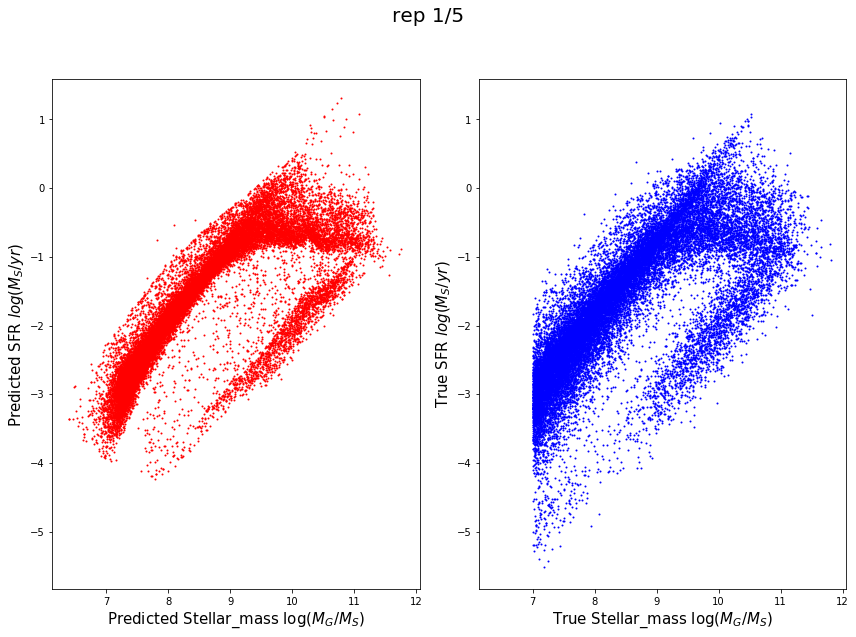

Train on 10000 samples, validate on 25000 samples
Epoch 1/1000
10000/10000 [==============================] - 0s 17us/step - loss: 1.4711e-05 - Stellar_mass_loss: 1.1230e-06 - SFR_loss: 1.3588e-05 - val_loss: 6.4052e-06 - val_Stellar_mass_loss: 5.1370e-07 - val_SFR_loss: 5.8915e-06
Epoch 2/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4753e-05 - Stellar_mass_loss: 1.1159e-06 - SFR_loss: 1.3637e-05 - val_loss: 6.4061e-06 - val_Stellar_mass_loss: 5.1172e-07 - val_SFR_loss: 5.8943e-06
Epoch 3/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4792e-05 - Stellar_mass_loss: 1.1263e-06 - SFR_loss: 1.3666e-05 - val_loss: 6.4187e-06 - val_Stellar_mass_loss: 5.0444e-07 - val_SFR_loss: 5.9142e-06
Epoch 4/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4712e-05 - Stellar_mass_loss: 1.0951e-06 - SFR_loss: 1.3617e-05 - val_loss: 6.4275e-06 - val_Stellar_mass_loss: 5.1815e-07 - val_SFR_loss: 5.9093e-06
Epoch 5/1000
10000

Epoch 36/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4749e-05 - Stellar_mass_loss: 1.1151e-06 - SFR_loss: 1.3633e-05 - val_loss: 6.3686e-06 - val_Stellar_mass_loss: 5.1093e-07 - val_SFR_loss: 5.8577e-06
Epoch 37/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4710e-05 - Stellar_mass_loss: 1.1207e-06 - SFR_loss: 1.3589e-05 - val_loss: 6.3688e-06 - val_Stellar_mass_loss: 5.0822e-07 - val_SFR_loss: 5.8606e-06
Epoch 38/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4727e-05 - Stellar_mass_loss: 1.1480e-06 - SFR_loss: 1.3579e-05 - val_loss: 6.4220e-06 - val_Stellar_mass_loss: 5.2739e-07 - val_SFR_loss: 5.8946e-06
Epoch 39/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4675e-05 - Stellar_mass_loss: 1.0958e-06 - SFR_loss: 1.3579e-05 - val_loss: 6.3650e-06 - val_Stellar_mass_loss: 4.9340e-07 - val_SFR_loss: 5.8716e-06
Epoch 40/1000
10000/10000 [==============================] - 0s 

10000/10000 [==============================] - 0s 19us/step - loss: 1.4703e-05 - Stellar_mass_loss: 1.1038e-06 - SFR_loss: 1.3599e-05 - val_loss: 6.4265e-06 - val_Stellar_mass_loss: 5.2544e-07 - val_SFR_loss: 5.9010e-06
Epoch 72/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4727e-05 - Stellar_mass_loss: 1.0835e-06 - SFR_loss: 1.3644e-05 - val_loss: 6.4444e-06 - val_Stellar_mass_loss: 5.1303e-07 - val_SFR_loss: 5.9313e-06
Epoch 73/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4774e-05 - Stellar_mass_loss: 1.1664e-06 - SFR_loss: 1.3608e-05 - val_loss: 6.3772e-06 - val_Stellar_mass_loss: 4.8198e-07 - val_SFR_loss: 5.8952e-06
Epoch 74/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4676e-05 - Stellar_mass_loss: 1.0987e-06 - SFR_loss: 1.3577e-05 - val_loss: 6.4252e-06 - val_Stellar_mass_loss: 5.6854e-07 - val_SFR_loss: 5.8566e-06
Epoch 75/1000
10000/10000 [==============================] - 0s 20us/step - lo

10000/10000 [==============================] - 0s 20us/step - loss: 1.4552e-05 - Stellar_mass_loss: 1.0849e-06 - SFR_loss: 1.3467e-05 - val_loss: 6.3970e-06 - val_Stellar_mass_loss: 5.1304e-07 - val_SFR_loss: 5.8839e-06
Epoch 107/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4560e-05 - Stellar_mass_loss: 1.0526e-06 - SFR_loss: 1.3508e-05 - val_loss: 6.3496e-06 - val_Stellar_mass_loss: 4.9348e-07 - val_SFR_loss: 5.8562e-06
Epoch 108/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4561e-05 - Stellar_mass_loss: 1.0721e-06 - SFR_loss: 1.3489e-05 - val_loss: 6.3691e-06 - val_Stellar_mass_loss: 5.1510e-07 - val_SFR_loss: 5.8540e-06
Epoch 109/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4652e-05 - Stellar_mass_loss: 1.1220e-06 - SFR_loss: 1.3530e-05 - val_loss: 6.3497e-06 - val_Stellar_mass_loss: 4.7626e-07 - val_SFR_loss: 5.8735e-06
Epoch 110/1000
10000/10000 [==============================] - 0s 20us/step 

Epoch 141/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4548e-05 - Stellar_mass_loss: 1.1087e-06 - SFR_loss: 1.3439e-05 - val_loss: 6.3632e-06 - val_Stellar_mass_loss: 5.1897e-07 - val_SFR_loss: 5.8442e-06
Epoch 142/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4557e-05 - Stellar_mass_loss: 1.0560e-06 - SFR_loss: 1.3501e-05 - val_loss: 6.3705e-06 - val_Stellar_mass_loss: 4.8480e-07 - val_SFR_loss: 5.8857e-06
Epoch 143/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4643e-05 - Stellar_mass_loss: 1.1091e-06 - SFR_loss: 1.3534e-05 - val_loss: 6.4457e-06 - val_Stellar_mass_loss: 5.3629e-07 - val_SFR_loss: 5.9094e-06
Epoch 144/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4568e-05 - Stellar_mass_loss: 1.0748e-06 - SFR_loss: 1.3494e-05 - val_loss: 6.3812e-06 - val_Stellar_mass_loss: 5.1385e-07 - val_SFR_loss: 5.8674e-06
Epoch 145/1000
10000/10000 [==============================] 

Epoch 176/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4431e-05 - Stellar_mass_loss: 1.0423e-06 - SFR_loss: 1.3389e-05 - val_loss: 6.4208e-06 - val_Stellar_mass_loss: 5.2220e-07 - val_SFR_loss: 5.8986e-06
Epoch 177/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4538e-05 - Stellar_mass_loss: 1.0635e-06 - SFR_loss: 1.3474e-05 - val_loss: 6.3405e-06 - val_Stellar_mass_loss: 5.0428e-07 - val_SFR_loss: 5.8362e-06
Epoch 178/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4485e-05 - Stellar_mass_loss: 1.0726e-06 - SFR_loss: 1.3413e-05 - val_loss: 6.3515e-06 - val_Stellar_mass_loss: 5.0198e-07 - val_SFR_loss: 5.8495e-06
Epoch 179/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4640e-05 - Stellar_mass_loss: 1.1040e-06 - SFR_loss: 1.3536e-05 - val_loss: 6.3595e-06 - val_Stellar_mass_loss: 5.0046e-07 - val_SFR_loss: 5.8591e-06
Epoch 180/1000
10000/10000 [==============================] 

Epoch 211/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4540e-05 - Stellar_mass_loss: 1.0940e-06 - SFR_loss: 1.3446e-05 - val_loss: 6.4170e-06 - val_Stellar_mass_loss: 5.3425e-07 - val_SFR_loss: 5.8828e-06
Epoch 212/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4532e-05 - Stellar_mass_loss: 1.0731e-06 - SFR_loss: 1.3459e-05 - val_loss: 6.3561e-06 - val_Stellar_mass_loss: 4.9454e-07 - val_SFR_loss: 5.8616e-06
Epoch 213/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4546e-05 - Stellar_mass_loss: 1.1340e-06 - SFR_loss: 1.3412e-05 - val_loss: 6.3394e-06 - val_Stellar_mass_loss: 4.8048e-07 - val_SFR_loss: 5.8590e-06
Epoch 214/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4507e-05 - Stellar_mass_loss: 1.0946e-06 - SFR_loss: 1.3412e-05 - val_loss: 6.3636e-06 - val_Stellar_mass_loss: 5.1869e-07 - val_SFR_loss: 5.8450e-06
Epoch 215/1000
10000/10000 [==============================] 

Epoch 246/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4419e-05 - Stellar_mass_loss: 1.0873e-06 - SFR_loss: 1.3331e-05 - val_loss: 6.2901e-06 - val_Stellar_mass_loss: 4.7568e-07 - val_SFR_loss: 5.8144e-06
Epoch 247/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4462e-05 - Stellar_mass_loss: 1.1006e-06 - SFR_loss: 1.3361e-05 - val_loss: 6.3852e-06 - val_Stellar_mass_loss: 5.6448e-07 - val_SFR_loss: 5.8208e-06
Epoch 248/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4405e-05 - Stellar_mass_loss: 1.0771e-06 - SFR_loss: 1.3328e-05 - val_loss: 6.3145e-06 - val_Stellar_mass_loss: 5.1260e-07 - val_SFR_loss: 5.8019e-06
Epoch 249/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4422e-05 - Stellar_mass_loss: 1.0952e-06 - SFR_loss: 1.3327e-05 - val_loss: 6.3152e-06 - val_Stellar_mass_loss: 4.8304e-07 - val_SFR_loss: 5.8321e-06
Epoch 250/1000
10000/10000 [==============================] 

Epoch 281/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4452e-05 - Stellar_mass_loss: 1.0867e-06 - SFR_loss: 1.3365e-05 - val_loss: 6.3240e-06 - val_Stellar_mass_loss: 5.2393e-07 - val_SFR_loss: 5.8000e-06
Epoch 282/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4534e-05 - Stellar_mass_loss: 1.0924e-06 - SFR_loss: 1.3442e-05 - val_loss: 6.3537e-06 - val_Stellar_mass_loss: 5.1872e-07 - val_SFR_loss: 5.8350e-06
Epoch 283/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4582e-05 - Stellar_mass_loss: 1.0902e-06 - SFR_loss: 1.3492e-05 - val_loss: 6.4144e-06 - val_Stellar_mass_loss: 5.3640e-07 - val_SFR_loss: 5.8780e-06
Epoch 284/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4520e-05 - Stellar_mass_loss: 1.0608e-06 - SFR_loss: 1.3459e-05 - val_loss: 6.3723e-06 - val_Stellar_mass_loss: 5.1650e-07 - val_SFR_loss: 5.8558e-06
Epoch 285/1000
10000/10000 [==============================] 

Epoch 316/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4327e-05 - Stellar_mass_loss: 1.0646e-06 - SFR_loss: 1.3263e-05 - val_loss: 6.3458e-06 - val_Stellar_mass_loss: 5.2813e-07 - val_SFR_loss: 5.8177e-06
Epoch 317/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4374e-05 - Stellar_mass_loss: 1.0751e-06 - SFR_loss: 1.3299e-05 - val_loss: 6.3108e-06 - val_Stellar_mass_loss: 5.1951e-07 - val_SFR_loss: 5.7913e-06
Epoch 318/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4375e-05 - Stellar_mass_loss: 1.0626e-06 - SFR_loss: 1.3313e-05 - val_loss: 6.3659e-06 - val_Stellar_mass_loss: 5.5304e-07 - val_SFR_loss: 5.8129e-06
Epoch 319/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4405e-05 - Stellar_mass_loss: 1.1174e-06 - SFR_loss: 1.3288e-05 - val_loss: 6.4128e-06 - val_Stellar_mass_loss: 5.8984e-07 - val_SFR_loss: 5.8229e-06
Epoch 320/1000
10000/10000 [==============================] 

Epoch 351/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4403e-05 - Stellar_mass_loss: 1.0636e-06 - SFR_loss: 1.3340e-05 - val_loss: 6.3814e-06 - val_Stellar_mass_loss: 5.1444e-07 - val_SFR_loss: 5.8669e-06
Epoch 352/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4363e-05 - Stellar_mass_loss: 1.0526e-06 - SFR_loss: 1.3310e-05 - val_loss: 6.3047e-06 - val_Stellar_mass_loss: 4.8980e-07 - val_SFR_loss: 5.8149e-06
Epoch 353/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4396e-05 - Stellar_mass_loss: 1.0785e-06 - SFR_loss: 1.3317e-05 - val_loss: 6.3433e-06 - val_Stellar_mass_loss: 5.2504e-07 - val_SFR_loss: 5.8183e-06
Epoch 354/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4318e-05 - Stellar_mass_loss: 1.0319e-06 - SFR_loss: 1.3286e-05 - val_loss: 6.2750e-06 - val_Stellar_mass_loss: 4.8483e-07 - val_SFR_loss: 5.7902e-06
Epoch 355/1000
10000/10000 [==============================] 

Epoch 386/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4371e-05 - Stellar_mass_loss: 1.1372e-06 - SFR_loss: 1.3234e-05 - val_loss: 6.3287e-06 - val_Stellar_mass_loss: 5.3220e-07 - val_SFR_loss: 5.7965e-06
Epoch 387/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4349e-05 - Stellar_mass_loss: 1.0896e-06 - SFR_loss: 1.3260e-05 - val_loss: 6.3580e-06 - val_Stellar_mass_loss: 5.6543e-07 - val_SFR_loss: 5.7925e-06
Epoch 388/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4397e-05 - Stellar_mass_loss: 1.0977e-06 - SFR_loss: 1.3299e-05 - val_loss: 6.3310e-06 - val_Stellar_mass_loss: 5.3091e-07 - val_SFR_loss: 5.8001e-06
Epoch 389/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4489e-05 - Stellar_mass_loss: 1.0624e-06 - SFR_loss: 1.3427e-05 - val_loss: 6.3342e-06 - val_Stellar_mass_loss: 5.1677e-07 - val_SFR_loss: 5.8175e-06
Epoch 390/1000
10000/10000 [==============================] 

Epoch 421/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4221e-05 - Stellar_mass_loss: 1.0655e-06 - SFR_loss: 1.3155e-05 - val_loss: 6.3629e-06 - val_Stellar_mass_loss: 5.4365e-07 - val_SFR_loss: 5.8192e-06
Epoch 422/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4341e-05 - Stellar_mass_loss: 1.1395e-06 - SFR_loss: 1.3201e-05 - val_loss: 6.2593e-06 - val_Stellar_mass_loss: 4.6874e-07 - val_SFR_loss: 5.7905e-06
Epoch 423/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4231e-05 - Stellar_mass_loss: 1.0732e-06 - SFR_loss: 1.3158e-05 - val_loss: 6.2841e-06 - val_Stellar_mass_loss: 5.0836e-07 - val_SFR_loss: 5.7758e-06
Epoch 424/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4260e-05 - Stellar_mass_loss: 1.0434e-06 - SFR_loss: 1.3216e-05 - val_loss: 6.2588e-06 - val_Stellar_mass_loss: 4.8204e-07 - val_SFR_loss: 5.7768e-06
Epoch 425/1000
10000/10000 [==============================] 

Epoch 456/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4174e-05 - Stellar_mass_loss: 1.0344e-06 - SFR_loss: 1.3139e-05 - val_loss: 6.3298e-06 - val_Stellar_mass_loss: 5.3396e-07 - val_SFR_loss: 5.7958e-06
Epoch 457/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4199e-05 - Stellar_mass_loss: 1.0561e-06 - SFR_loss: 1.3142e-05 - val_loss: 6.2721e-06 - val_Stellar_mass_loss: 5.0662e-07 - val_SFR_loss: 5.7655e-06
Epoch 458/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4166e-05 - Stellar_mass_loss: 1.0562e-06 - SFR_loss: 1.3110e-05 - val_loss: 6.2991e-06 - val_Stellar_mass_loss: 5.1264e-07 - val_SFR_loss: 5.7864e-06
Epoch 459/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4146e-05 - Stellar_mass_loss: 1.0404e-06 - SFR_loss: 1.3106e-05 - val_loss: 6.2614e-06 - val_Stellar_mass_loss: 4.9480e-07 - val_SFR_loss: 5.7666e-06
Epoch 460/1000
10000/10000 [==============================] 

Epoch 491/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4322e-05 - Stellar_mass_loss: 1.1430e-06 - SFR_loss: 1.3179e-05 - val_loss: 6.2710e-06 - val_Stellar_mass_loss: 5.1072e-07 - val_SFR_loss: 5.7603e-06
Epoch 492/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4271e-05 - Stellar_mass_loss: 1.1779e-06 - SFR_loss: 1.3093e-05 - val_loss: 6.3164e-06 - val_Stellar_mass_loss: 5.3852e-07 - val_SFR_loss: 5.7779e-06
Epoch 493/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4195e-05 - Stellar_mass_loss: 1.0804e-06 - SFR_loss: 1.3114e-05 - val_loss: 6.2643e-06 - val_Stellar_mass_loss: 4.9650e-07 - val_SFR_loss: 5.7678e-06
Epoch 494/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4173e-05 - Stellar_mass_loss: 1.0761e-06 - SFR_loss: 1.3097e-05 - val_loss: 6.3023e-06 - val_Stellar_mass_loss: 5.5061e-07 - val_SFR_loss: 5.7516e-06
Epoch 495/1000
10000/10000 [==============================] 

Epoch 526/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4271e-05 - Stellar_mass_loss: 1.0944e-06 - SFR_loss: 1.3176e-05 - val_loss: 6.2576e-06 - val_Stellar_mass_loss: 4.7809e-07 - val_SFR_loss: 5.7795e-06
Epoch 527/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4249e-05 - Stellar_mass_loss: 1.0832e-06 - SFR_loss: 1.3166e-05 - val_loss: 6.3473e-06 - val_Stellar_mass_loss: 5.0976e-07 - val_SFR_loss: 5.8375e-06
Epoch 528/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4277e-05 - Stellar_mass_loss: 1.1335e-06 - SFR_loss: 1.3144e-05 - val_loss: 6.3107e-06 - val_Stellar_mass_loss: 5.2449e-07 - val_SFR_loss: 5.7862e-06
Epoch 529/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4261e-05 - Stellar_mass_loss: 1.0888e-06 - SFR_loss: 1.3172e-05 - val_loss: 6.3453e-06 - val_Stellar_mass_loss: 5.2905e-07 - val_SFR_loss: 5.8162e-06
Epoch 530/1000
10000/10000 [==============================] 

Epoch 561/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4253e-05 - Stellar_mass_loss: 1.1150e-06 - SFR_loss: 1.3138e-05 - val_loss: 6.2302e-06 - val_Stellar_mass_loss: 4.7287e-07 - val_SFR_loss: 5.7573e-06
Epoch 562/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4085e-05 - Stellar_mass_loss: 1.0279e-06 - SFR_loss: 1.3057e-05 - val_loss: 6.2602e-06 - val_Stellar_mass_loss: 4.8603e-07 - val_SFR_loss: 5.7742e-06
Epoch 563/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4119e-05 - Stellar_mass_loss: 1.0326e-06 - SFR_loss: 1.3087e-05 - val_loss: 6.2342e-06 - val_Stellar_mass_loss: 4.8051e-07 - val_SFR_loss: 5.7537e-06
Epoch 564/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4079e-05 - Stellar_mass_loss: 1.0218e-06 - SFR_loss: 1.3057e-05 - val_loss: 6.2954e-06 - val_Stellar_mass_loss: 5.0410e-07 - val_SFR_loss: 5.7913e-06
Epoch 565/1000
10000/10000 [==============================] 

Epoch 596/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4156e-05 - Stellar_mass_loss: 1.0185e-06 - SFR_loss: 1.3138e-05 - val_loss: 6.2790e-06 - val_Stellar_mass_loss: 5.0707e-07 - val_SFR_loss: 5.7720e-06
Epoch 597/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4135e-05 - Stellar_mass_loss: 1.0160e-06 - SFR_loss: 1.3119e-05 - val_loss: 6.2834e-06 - val_Stellar_mass_loss: 5.1382e-07 - val_SFR_loss: 5.7695e-06
Epoch 598/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4074e-05 - Stellar_mass_loss: 1.0374e-06 - SFR_loss: 1.3037e-05 - val_loss: 6.2519e-06 - val_Stellar_mass_loss: 4.8046e-07 - val_SFR_loss: 5.7714e-06
Epoch 599/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4035e-05 - Stellar_mass_loss: 1.0034e-06 - SFR_loss: 1.3032e-05 - val_loss: 6.2507e-06 - val_Stellar_mass_loss: 4.8494e-07 - val_SFR_loss: 5.7658e-06
Epoch 600/1000
10000/10000 [==============================] 

Epoch 631/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.4134e-05 - Stellar_mass_loss: 1.0464e-06 - SFR_loss: 1.3087e-05 - val_loss: 6.2735e-06 - val_Stellar_mass_loss: 4.9139e-07 - val_SFR_loss: 5.7821e-06
Epoch 632/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.4036e-05 - Stellar_mass_loss: 1.0406e-06 - SFR_loss: 1.2995e-05 - val_loss: 6.3184e-06 - val_Stellar_mass_loss: 5.2202e-07 - val_SFR_loss: 5.7964e-06
Epoch 633/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4122e-05 - Stellar_mass_loss: 1.0806e-06 - SFR_loss: 1.3042e-05 - val_loss: 6.3530e-06 - val_Stellar_mass_loss: 5.2386e-07 - val_SFR_loss: 5.8292e-06
Epoch 634/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4178e-05 - Stellar_mass_loss: 1.0603e-06 - SFR_loss: 1.3117e-05 - val_loss: 6.2828e-06 - val_Stellar_mass_loss: 5.0185e-07 - val_SFR_loss: 5.7809e-06
Epoch 635/1000
10000/10000 [==============================] 

Epoch 666/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3975e-05 - Stellar_mass_loss: 1.0402e-06 - SFR_loss: 1.2935e-05 - val_loss: 6.2244e-06 - val_Stellar_mass_loss: 4.8710e-07 - val_SFR_loss: 5.7373e-06
Epoch 667/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3977e-05 - Stellar_mass_loss: 1.0472e-06 - SFR_loss: 1.2930e-05 - val_loss: 6.3168e-06 - val_Stellar_mass_loss: 5.6462e-07 - val_SFR_loss: 5.7522e-06
Epoch 668/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3993e-05 - Stellar_mass_loss: 1.0580e-06 - SFR_loss: 1.2935e-05 - val_loss: 6.2929e-06 - val_Stellar_mass_loss: 5.3969e-07 - val_SFR_loss: 5.7532e-06
Epoch 669/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3975e-05 - Stellar_mass_loss: 1.0158e-06 - SFR_loss: 1.2959e-05 - val_loss: 6.2575e-06 - val_Stellar_mass_loss: 5.0530e-07 - val_SFR_loss: 5.7522e-06
Epoch 670/1000
10000/10000 [==============================] 

Epoch 701/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.4045e-05 - Stellar_mass_loss: 1.1028e-06 - SFR_loss: 1.2942e-05 - val_loss: 6.2840e-06 - val_Stellar_mass_loss: 5.2044e-07 - val_SFR_loss: 5.7636e-06
Epoch 702/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3974e-05 - Stellar_mass_loss: 1.0413e-06 - SFR_loss: 1.2933e-05 - val_loss: 6.2587e-06 - val_Stellar_mass_loss: 5.2368e-07 - val_SFR_loss: 5.7350e-06
Epoch 703/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3937e-05 - Stellar_mass_loss: 1.0422e-06 - SFR_loss: 1.2895e-05 - val_loss: 6.2605e-06 - val_Stellar_mass_loss: 5.1617e-07 - val_SFR_loss: 5.7444e-06
Epoch 704/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3976e-05 - Stellar_mass_loss: 1.0658e-06 - SFR_loss: 1.2910e-05 - val_loss: 6.2286e-06 - val_Stellar_mass_loss: 5.0093e-07 - val_SFR_loss: 5.7276e-06
Epoch 705/1000
10000/10000 [==============================] 

Epoch 736/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3966e-05 - Stellar_mass_loss: 1.0035e-06 - SFR_loss: 1.2962e-05 - val_loss: 6.2471e-06 - val_Stellar_mass_loss: 5.0332e-07 - val_SFR_loss: 5.7438e-06
Epoch 737/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3938e-05 - Stellar_mass_loss: 1.0265e-06 - SFR_loss: 1.2911e-05 - val_loss: 6.2252e-06 - val_Stellar_mass_loss: 4.9537e-07 - val_SFR_loss: 5.7298e-06
Epoch 738/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3899e-05 - Stellar_mass_loss: 9.9687e-07 - SFR_loss: 1.2902e-05 - val_loss: 6.2276e-06 - val_Stellar_mass_loss: 4.6874e-07 - val_SFR_loss: 5.7589e-06
Epoch 739/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3901e-05 - Stellar_mass_loss: 1.0056e-06 - SFR_loss: 1.2896e-05 - val_loss: 6.1912e-06 - val_Stellar_mass_loss: 4.6413e-07 - val_SFR_loss: 5.7271e-06
Epoch 740/1000
10000/10000 [==============================] 

Epoch 771/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3961e-05 - Stellar_mass_loss: 1.0701e-06 - SFR_loss: 1.2891e-05 - val_loss: 6.2538e-06 - val_Stellar_mass_loss: 4.7539e-07 - val_SFR_loss: 5.7784e-06
Epoch 772/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3993e-05 - Stellar_mass_loss: 1.0416e-06 - SFR_loss: 1.2951e-05 - val_loss: 6.2141e-06 - val_Stellar_mass_loss: 4.9054e-07 - val_SFR_loss: 5.7235e-06
Epoch 773/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3879e-05 - Stellar_mass_loss: 1.0315e-06 - SFR_loss: 1.2848e-05 - val_loss: 6.2272e-06 - val_Stellar_mass_loss: 4.9444e-07 - val_SFR_loss: 5.7328e-06
Epoch 774/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3855e-05 - Stellar_mass_loss: 1.0058e-06 - SFR_loss: 1.2850e-05 - val_loss: 6.2664e-06 - val_Stellar_mass_loss: 5.3416e-07 - val_SFR_loss: 5.7323e-06
Epoch 775/1000
10000/10000 [==============================] 

Epoch 806/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3964e-05 - Stellar_mass_loss: 9.9473e-07 - SFR_loss: 1.2969e-05 - val_loss: 6.2284e-06 - val_Stellar_mass_loss: 4.7559e-07 - val_SFR_loss: 5.7529e-06
Epoch 807/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3880e-05 - Stellar_mass_loss: 1.0262e-06 - SFR_loss: 1.2853e-05 - val_loss: 6.2515e-06 - val_Stellar_mass_loss: 4.9310e-07 - val_SFR_loss: 5.7584e-06
Epoch 808/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3930e-05 - Stellar_mass_loss: 1.0146e-06 - SFR_loss: 1.2916e-05 - val_loss: 6.2667e-06 - val_Stellar_mass_loss: 4.9370e-07 - val_SFR_loss: 5.7730e-06
Epoch 809/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.4003e-05 - Stellar_mass_loss: 1.0383e-06 - SFR_loss: 1.2964e-05 - val_loss: 6.2328e-06 - val_Stellar_mass_loss: 4.6915e-07 - val_SFR_loss: 5.7637e-06
Epoch 810/1000
10000/10000 [==============================] 

Epoch 841/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3872e-05 - Stellar_mass_loss: 9.8770e-07 - SFR_loss: 1.2884e-05 - val_loss: 6.2512e-06 - val_Stellar_mass_loss: 5.2600e-07 - val_SFR_loss: 5.7252e-06
Epoch 842/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3823e-05 - Stellar_mass_loss: 1.0643e-06 - SFR_loss: 1.2759e-05 - val_loss: 6.2343e-06 - val_Stellar_mass_loss: 5.0140e-07 - val_SFR_loss: 5.7329e-06
Epoch 843/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3836e-05 - Stellar_mass_loss: 1.0331e-06 - SFR_loss: 1.2803e-05 - val_loss: 6.1978e-06 - val_Stellar_mass_loss: 4.9662e-07 - val_SFR_loss: 5.7012e-06
Epoch 844/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3796e-05 - Stellar_mass_loss: 1.0092e-06 - SFR_loss: 1.2786e-05 - val_loss: 6.2178e-06 - val_Stellar_mass_loss: 4.9972e-07 - val_SFR_loss: 5.7181e-06
Epoch 845/1000
10000/10000 [==============================] 

Epoch 876/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3825e-05 - Stellar_mass_loss: 1.0067e-06 - SFR_loss: 1.2818e-05 - val_loss: 6.2151e-06 - val_Stellar_mass_loss: 4.7727e-07 - val_SFR_loss: 5.7379e-06
Epoch 877/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3820e-05 - Stellar_mass_loss: 9.7829e-07 - SFR_loss: 1.2842e-05 - val_loss: 6.2019e-06 - val_Stellar_mass_loss: 4.6734e-07 - val_SFR_loss: 5.7346e-06
Epoch 878/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3853e-05 - Stellar_mass_loss: 9.9243e-07 - SFR_loss: 1.2861e-05 - val_loss: 6.1904e-06 - val_Stellar_mass_loss: 4.7574e-07 - val_SFR_loss: 5.7146e-06
Epoch 879/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3813e-05 - Stellar_mass_loss: 1.0518e-06 - SFR_loss: 1.2761e-05 - val_loss: 6.2045e-06 - val_Stellar_mass_loss: 4.8056e-07 - val_SFR_loss: 5.7239e-06
Epoch 880/1000
10000/10000 [==============================] 

Epoch 911/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3851e-05 - Stellar_mass_loss: 1.0515e-06 - SFR_loss: 1.2800e-05 - val_loss: 6.2430e-06 - val_Stellar_mass_loss: 5.0040e-07 - val_SFR_loss: 5.7426e-06
Epoch 912/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3863e-05 - Stellar_mass_loss: 1.0664e-06 - SFR_loss: 1.2796e-05 - val_loss: 6.1830e-06 - val_Stellar_mass_loss: 4.8523e-07 - val_SFR_loss: 5.6978e-06
Epoch 913/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3786e-05 - Stellar_mass_loss: 1.0386e-06 - SFR_loss: 1.2748e-05 - val_loss: 6.2221e-06 - val_Stellar_mass_loss: 5.0976e-07 - val_SFR_loss: 5.7123e-06
Epoch 914/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3812e-05 - Stellar_mass_loss: 1.0578e-06 - SFR_loss: 1.2754e-05 - val_loss: 6.2575e-06 - val_Stellar_mass_loss: 5.4578e-07 - val_SFR_loss: 5.7117e-06
Epoch 915/1000
10000/10000 [==============================] 

Epoch 946/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3766e-05 - Stellar_mass_loss: 1.0337e-06 - SFR_loss: 1.2732e-05 - val_loss: 6.1706e-06 - val_Stellar_mass_loss: 4.6823e-07 - val_SFR_loss: 5.7024e-06
Epoch 947/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3795e-05 - Stellar_mass_loss: 1.0274e-06 - SFR_loss: 1.2768e-05 - val_loss: 6.1897e-06 - val_Stellar_mass_loss: 4.7582e-07 - val_SFR_loss: 5.7139e-06
Epoch 948/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3778e-05 - Stellar_mass_loss: 1.0601e-06 - SFR_loss: 1.2717e-05 - val_loss: 6.1723e-06 - val_Stellar_mass_loss: 4.8110e-07 - val_SFR_loss: 5.6912e-06
Epoch 949/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3768e-05 - Stellar_mass_loss: 1.0432e-06 - SFR_loss: 1.2725e-05 - val_loss: 6.1644e-06 - val_Stellar_mass_loss: 4.5861e-07 - val_SFR_loss: 5.7058e-06
Epoch 950/1000
10000/10000 [==============================] 

Epoch 981/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3903e-05 - Stellar_mass_loss: 1.0461e-06 - SFR_loss: 1.2857e-05 - val_loss: 6.2307e-06 - val_Stellar_mass_loss: 5.2309e-07 - val_SFR_loss: 5.7076e-06
Epoch 982/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3880e-05 - Stellar_mass_loss: 1.0116e-06 - SFR_loss: 1.2869e-05 - val_loss: 6.1958e-06 - val_Stellar_mass_loss: 4.9189e-07 - val_SFR_loss: 5.7039e-06
Epoch 983/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3844e-05 - Stellar_mass_loss: 1.0206e-06 - SFR_loss: 1.2823e-05 - val_loss: 6.2213e-06 - val_Stellar_mass_loss: 4.8657e-07 - val_SFR_loss: 5.7347e-06
Epoch 984/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3888e-05 - Stellar_mass_loss: 1.0743e-06 - SFR_loss: 1.2814e-05 - val_loss: 6.1517e-06 - val_Stellar_mass_loss: 4.5769e-07 - val_SFR_loss: 5.6941e-06
Epoch 985/1000
10000/10000 [==============================] 

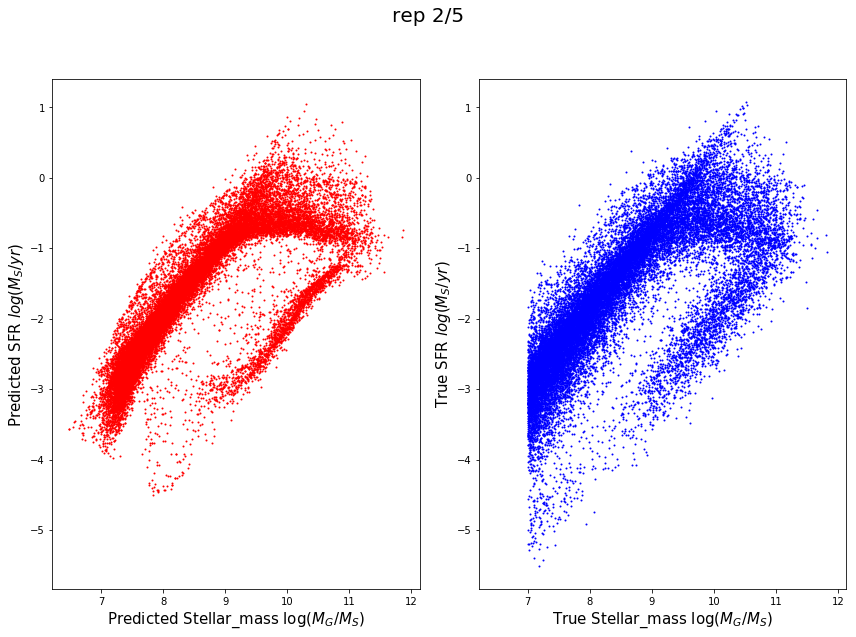

Train on 10000 samples, validate on 25000 samples
Epoch 1/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3801e-05 - Stellar_mass_loss: 1.0916e-06 - SFR_loss: 1.2710e-05 - val_loss: 6.1994e-06 - val_Stellar_mass_loss: 4.8734e-07 - val_SFR_loss: 5.7121e-06
Epoch 2/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3739e-05 - Stellar_mass_loss: 1.0390e-06 - SFR_loss: 1.2700e-05 - val_loss: 6.1384e-06 - val_Stellar_mass_loss: 4.6311e-07 - val_SFR_loss: 5.6753e-06
Epoch 3/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3763e-05 - Stellar_mass_loss: 9.9136e-07 - SFR_loss: 1.2772e-05 - val_loss: 6.1837e-06 - val_Stellar_mass_loss: 4.6918e-07 - val_SFR_loss: 5.7145e-06
Epoch 4/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3741e-05 - Stellar_mass_loss: 9.6288e-07 - SFR_loss: 1.2778e-05 - val_loss: 6.2061e-06 - val_Stellar_mass_loss: 4.9005e-07 - val_SFR_loss: 5.7161e-06
Epoch 5/1000
10000

Epoch 36/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3756e-05 - Stellar_mass_loss: 9.8225e-07 - SFR_loss: 1.2774e-05 - val_loss: 6.2768e-06 - val_Stellar_mass_loss: 5.2172e-07 - val_SFR_loss: 5.7551e-06
Epoch 37/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3718e-05 - Stellar_mass_loss: 9.8657e-07 - SFR_loss: 1.2732e-05 - val_loss: 6.1634e-06 - val_Stellar_mass_loss: 4.6790e-07 - val_SFR_loss: 5.6955e-06
Epoch 38/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3784e-05 - Stellar_mass_loss: 1.0594e-06 - SFR_loss: 1.2724e-05 - val_loss: 6.1698e-06 - val_Stellar_mass_loss: 4.7770e-07 - val_SFR_loss: 5.6921e-06
Epoch 39/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3621e-05 - Stellar_mass_loss: 9.6375e-07 - SFR_loss: 1.2658e-05 - val_loss: 6.2015e-06 - val_Stellar_mass_loss: 5.0180e-07 - val_SFR_loss: 5.6997e-06
Epoch 40/1000
10000/10000 [==============================] - 0s 

10000/10000 [==============================] - 0s 21us/step - loss: 1.3767e-05 - Stellar_mass_loss: 1.1136e-06 - SFR_loss: 1.2653e-05 - val_loss: 6.2177e-06 - val_Stellar_mass_loss: 5.3035e-07 - val_SFR_loss: 5.6873e-06
Epoch 72/1000
10000/10000 [==============================] - 0s 22us/step - loss: 1.3891e-05 - Stellar_mass_loss: 1.1579e-06 - SFR_loss: 1.2733e-05 - val_loss: 6.2066e-06 - val_Stellar_mass_loss: 5.1348e-07 - val_SFR_loss: 5.6931e-06
Epoch 73/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3650e-05 - Stellar_mass_loss: 9.8070e-07 - SFR_loss: 1.2669e-05 - val_loss: 6.2269e-06 - val_Stellar_mass_loss: 5.2331e-07 - val_SFR_loss: 5.7036e-06
Epoch 74/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3671e-05 - Stellar_mass_loss: 9.9911e-07 - SFR_loss: 1.2672e-05 - val_loss: 6.1797e-06 - val_Stellar_mass_loss: 4.9675e-07 - val_SFR_loss: 5.6829e-06
Epoch 75/1000
10000/10000 [==============================] - 0s 19us/step - lo

10000/10000 [==============================] - 0s 20us/step - loss: 1.3732e-05 - Stellar_mass_loss: 9.5719e-07 - SFR_loss: 1.2775e-05 - val_loss: 6.1754e-06 - val_Stellar_mass_loss: 4.8840e-07 - val_SFR_loss: 5.6870e-06
Epoch 107/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3717e-05 - Stellar_mass_loss: 1.0157e-06 - SFR_loss: 1.2702e-05 - val_loss: 6.1952e-06 - val_Stellar_mass_loss: 4.9880e-07 - val_SFR_loss: 5.6964e-06
Epoch 108/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3695e-05 - Stellar_mass_loss: 1.0226e-06 - SFR_loss: 1.2673e-05 - val_loss: 6.1867e-06 - val_Stellar_mass_loss: 4.8238e-07 - val_SFR_loss: 5.7043e-06
Epoch 109/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3793e-05 - Stellar_mass_loss: 1.0968e-06 - SFR_loss: 1.2696e-05 - val_loss: 6.2285e-06 - val_Stellar_mass_loss: 4.9803e-07 - val_SFR_loss: 5.7305e-06
Epoch 110/1000
10000/10000 [==============================] - 0s 21us/step 

Epoch 141/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3576e-05 - Stellar_mass_loss: 9.3691e-07 - SFR_loss: 1.2639e-05 - val_loss: 6.1888e-06 - val_Stellar_mass_loss: 5.2312e-07 - val_SFR_loss: 5.6657e-06
Epoch 142/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3543e-05 - Stellar_mass_loss: 9.4646e-07 - SFR_loss: 1.2597e-05 - val_loss: 6.1601e-06 - val_Stellar_mass_loss: 5.0857e-07 - val_SFR_loss: 5.6515e-06
Epoch 143/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3600e-05 - Stellar_mass_loss: 9.6350e-07 - SFR_loss: 1.2637e-05 - val_loss: 6.1854e-06 - val_Stellar_mass_loss: 5.1773e-07 - val_SFR_loss: 5.6677e-06
Epoch 144/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3562e-05 - Stellar_mass_loss: 9.4811e-07 - SFR_loss: 1.2614e-05 - val_loss: 6.2351e-06 - val_Stellar_mass_loss: 5.5507e-07 - val_SFR_loss: 5.6800e-06
Epoch 145/1000
10000/10000 [==============================] 

Epoch 176/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3690e-05 - Stellar_mass_loss: 1.0560e-06 - SFR_loss: 1.2635e-05 - val_loss: 6.1472e-06 - val_Stellar_mass_loss: 4.8449e-07 - val_SFR_loss: 5.6627e-06
Epoch 177/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3556e-05 - Stellar_mass_loss: 9.6688e-07 - SFR_loss: 1.2589e-05 - val_loss: 6.1882e-06 - val_Stellar_mass_loss: 5.2253e-07 - val_SFR_loss: 5.6657e-06
Epoch 178/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3580e-05 - Stellar_mass_loss: 9.9046e-07 - SFR_loss: 1.2590e-05 - val_loss: 6.1924e-06 - val_Stellar_mass_loss: 5.4086e-07 - val_SFR_loss: 5.6515e-06
Epoch 179/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3546e-05 - Stellar_mass_loss: 9.5685e-07 - SFR_loss: 1.2590e-05 - val_loss: 6.1740e-06 - val_Stellar_mass_loss: 5.0217e-07 - val_SFR_loss: 5.6718e-06
Epoch 180/1000
10000/10000 [==============================] 

Epoch 211/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3474e-05 - Stellar_mass_loss: 9.3896e-07 - SFR_loss: 1.2535e-05 - val_loss: 6.2203e-06 - val_Stellar_mass_loss: 5.8138e-07 - val_SFR_loss: 5.6389e-06
Epoch 212/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3529e-05 - Stellar_mass_loss: 9.9161e-07 - SFR_loss: 1.2538e-05 - val_loss: 6.2359e-06 - val_Stellar_mass_loss: 5.6763e-07 - val_SFR_loss: 5.6682e-06
Epoch 213/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3648e-05 - Stellar_mass_loss: 9.5930e-07 - SFR_loss: 1.2689e-05 - val_loss: 6.1683e-06 - val_Stellar_mass_loss: 5.2989e-07 - val_SFR_loss: 5.6384e-06
Epoch 214/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3668e-05 - Stellar_mass_loss: 9.7669e-07 - SFR_loss: 1.2691e-05 - val_loss: 6.2208e-06 - val_Stellar_mass_loss: 5.4317e-07 - val_SFR_loss: 5.6777e-06
Epoch 215/1000
10000/10000 [==============================] 

Epoch 246/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3435e-05 - Stellar_mass_loss: 8.8722e-07 - SFR_loss: 1.2547e-05 - val_loss: 6.2446e-06 - val_Stellar_mass_loss: 5.5145e-07 - val_SFR_loss: 5.6931e-06
Epoch 247/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3476e-05 - Stellar_mass_loss: 9.4085e-07 - SFR_loss: 1.2535e-05 - val_loss: 6.2062e-06 - val_Stellar_mass_loss: 5.6717e-07 - val_SFR_loss: 5.6390e-06
Epoch 248/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3474e-05 - Stellar_mass_loss: 9.2123e-07 - SFR_loss: 1.2553e-05 - val_loss: 6.1779e-06 - val_Stellar_mass_loss: 5.5298e-07 - val_SFR_loss: 5.6249e-06
Epoch 249/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3467e-05 - Stellar_mass_loss: 9.3709e-07 - SFR_loss: 1.2530e-05 - val_loss: 6.2052e-06 - val_Stellar_mass_loss: 5.5531e-07 - val_SFR_loss: 5.6498e-06
Epoch 250/1000
10000/10000 [==============================] 

Epoch 281/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3475e-05 - Stellar_mass_loss: 9.3079e-07 - SFR_loss: 1.2544e-05 - val_loss: 6.2320e-06 - val_Stellar_mass_loss: 5.6140e-07 - val_SFR_loss: 5.6706e-06
Epoch 282/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3540e-05 - Stellar_mass_loss: 9.0793e-07 - SFR_loss: 1.2632e-05 - val_loss: 6.2010e-06 - val_Stellar_mass_loss: 5.5325e-07 - val_SFR_loss: 5.6478e-06
Epoch 283/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3412e-05 - Stellar_mass_loss: 8.9898e-07 - SFR_loss: 1.2513e-05 - val_loss: 6.2454e-06 - val_Stellar_mass_loss: 5.9432e-07 - val_SFR_loss: 5.6511e-06
Epoch 284/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3428e-05 - Stellar_mass_loss: 9.1372e-07 - SFR_loss: 1.2515e-05 - val_loss: 6.1990e-06 - val_Stellar_mass_loss: 5.6987e-07 - val_SFR_loss: 5.6292e-06
Epoch 285/1000
10000/10000 [==============================] 

Epoch 316/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3332e-05 - Stellar_mass_loss: 8.4718e-07 - SFR_loss: 1.2484e-05 - val_loss: 6.2641e-06 - val_Stellar_mass_loss: 6.0874e-07 - val_SFR_loss: 5.6554e-06
Epoch 317/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3438e-05 - Stellar_mass_loss: 8.6778e-07 - SFR_loss: 1.2570e-05 - val_loss: 6.2255e-06 - val_Stellar_mass_loss: 5.9722e-07 - val_SFR_loss: 5.6283e-06
Epoch 318/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3368e-05 - Stellar_mass_loss: 8.6946e-07 - SFR_loss: 1.2499e-05 - val_loss: 6.2158e-06 - val_Stellar_mass_loss: 5.6663e-07 - val_SFR_loss: 5.6492e-06
Epoch 319/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3360e-05 - Stellar_mass_loss: 8.8040e-07 - SFR_loss: 1.2479e-05 - val_loss: 6.2205e-06 - val_Stellar_mass_loss: 5.9266e-07 - val_SFR_loss: 5.6279e-06
Epoch 320/1000
10000/10000 [==============================] 

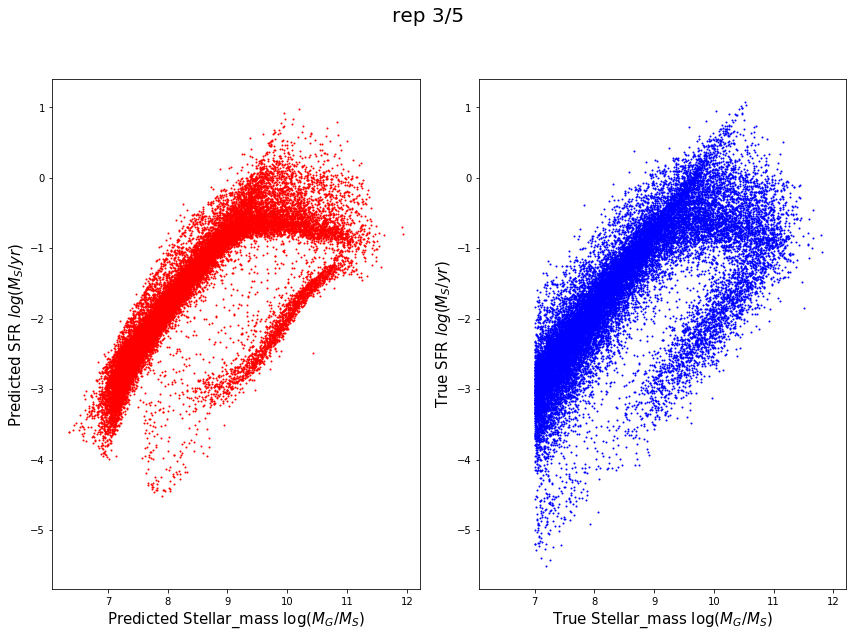

Train on 10000 samples, validate on 25000 samples
Epoch 1/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3466e-05 - Stellar_mass_loss: 1.0294e-06 - SFR_loss: 1.2436e-05 - val_loss: 6.2631e-06 - val_Stellar_mass_loss: 6.3570e-07 - val_SFR_loss: 5.6274e-06
Epoch 2/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3435e-05 - Stellar_mass_loss: 9.8375e-07 - SFR_loss: 1.2451e-05 - val_loss: 6.1645e-06 - val_Stellar_mass_loss: 5.4280e-07 - val_SFR_loss: 5.6217e-06
Epoch 3/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3434e-05 - Stellar_mass_loss: 9.4142e-07 - SFR_loss: 1.2493e-05 - val_loss: 6.1751e-06 - val_Stellar_mass_loss: 5.3376e-07 - val_SFR_loss: 5.6414e-06
Epoch 4/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3301e-05 - Stellar_mass_loss: 8.5452e-07 - SFR_loss: 1.2447e-05 - val_loss: 6.1718e-06 - val_Stellar_mass_loss: 5.5035e-07 - val_SFR_loss: 5.6215e-06
Epoch 5/1000
10000

Epoch 36/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3594e-05 - Stellar_mass_loss: 1.1379e-06 - SFR_loss: 1.2456e-05 - val_loss: 6.1789e-06 - val_Stellar_mass_loss: 5.5091e-07 - val_SFR_loss: 5.6280e-06
Epoch 37/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3559e-05 - Stellar_mass_loss: 1.0595e-06 - SFR_loss: 1.2500e-05 - val_loss: 6.1810e-06 - val_Stellar_mass_loss: 5.8061e-07 - val_SFR_loss: 5.6004e-06
Epoch 38/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3470e-05 - Stellar_mass_loss: 1.0568e-06 - SFR_loss: 1.2414e-05 - val_loss: 6.1554e-06 - val_Stellar_mass_loss: 5.7139e-07 - val_SFR_loss: 5.5840e-06
Epoch 39/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3384e-05 - Stellar_mass_loss: 1.0064e-06 - SFR_loss: 1.2377e-05 - val_loss: 6.1910e-06 - val_Stellar_mass_loss: 5.6045e-07 - val_SFR_loss: 5.6305e-06
Epoch 40/1000
10000/10000 [==============================] - 0s 

10000/10000 [==============================] - 0s 19us/step - loss: 1.3408e-05 - Stellar_mass_loss: 8.9021e-07 - SFR_loss: 1.2517e-05 - val_loss: 6.3289e-06 - val_Stellar_mass_loss: 6.0319e-07 - val_SFR_loss: 5.7257e-06
Epoch 72/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3373e-05 - Stellar_mass_loss: 8.3529e-07 - SFR_loss: 1.2538e-05 - val_loss: 6.1471e-06 - val_Stellar_mass_loss: 5.7925e-07 - val_SFR_loss: 5.5679e-06
Epoch 73/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3367e-05 - Stellar_mass_loss: 9.4343e-07 - SFR_loss: 1.2423e-05 - val_loss: 6.2883e-06 - val_Stellar_mass_loss: 6.4777e-07 - val_SFR_loss: 5.6405e-06
Epoch 74/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3504e-05 - Stellar_mass_loss: 9.9090e-07 - SFR_loss: 1.2513e-05 - val_loss: 6.2093e-06 - val_Stellar_mass_loss: 6.3191e-07 - val_SFR_loss: 5.5774e-06
Epoch 75/1000
10000/10000 [==============================] - 0s 20us/step - lo

10000/10000 [==============================] - 0s 20us/step - loss: 1.3170e-05 - Stellar_mass_loss: 8.2325e-07 - SFR_loss: 1.2346e-05 - val_loss: 6.1462e-06 - val_Stellar_mass_loss: 5.8008e-07 - val_SFR_loss: 5.5661e-06
Epoch 107/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3073e-05 - Stellar_mass_loss: 7.8395e-07 - SFR_loss: 1.2289e-05 - val_loss: 6.1327e-06 - val_Stellar_mass_loss: 5.7800e-07 - val_SFR_loss: 5.5547e-06
Epoch 108/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3108e-05 - Stellar_mass_loss: 7.7214e-07 - SFR_loss: 1.2336e-05 - val_loss: 6.1567e-06 - val_Stellar_mass_loss: 5.7485e-07 - val_SFR_loss: 5.5819e-06
Epoch 109/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3173e-05 - Stellar_mass_loss: 8.5232e-07 - SFR_loss: 1.2320e-05 - val_loss: 6.1705e-06 - val_Stellar_mass_loss: 6.0202e-07 - val_SFR_loss: 5.5684e-06
Epoch 110/1000
10000/10000 [==============================] - 0s 19us/step 

Epoch 141/1000
10000/10000 [==============================] - 0s 17us/step - loss: 1.3359e-05 - Stellar_mass_loss: 9.8345e-07 - SFR_loss: 1.2375e-05 - val_loss: 6.2003e-06 - val_Stellar_mass_loss: 6.0530e-07 - val_SFR_loss: 5.5950e-06
Epoch 142/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3411e-05 - Stellar_mass_loss: 9.1344e-07 - SFR_loss: 1.2497e-05 - val_loss: 6.1182e-06 - val_Stellar_mass_loss: 5.7206e-07 - val_SFR_loss: 5.5461e-06
Epoch 143/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3390e-05 - Stellar_mass_loss: 9.4126e-07 - SFR_loss: 1.2449e-05 - val_loss: 6.1533e-06 - val_Stellar_mass_loss: 5.8876e-07 - val_SFR_loss: 5.5645e-06
Epoch 144/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3225e-05 - Stellar_mass_loss: 9.1183e-07 - SFR_loss: 1.2313e-05 - val_loss: 6.1635e-06 - val_Stellar_mass_loss: 6.2461e-07 - val_SFR_loss: 5.5389e-06
Epoch 145/1000
10000/10000 [==============================] 

Epoch 176/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.3119e-05 - Stellar_mass_loss: 8.1180e-07 - SFR_loss: 1.2308e-05 - val_loss: 6.1354e-06 - val_Stellar_mass_loss: 5.8094e-07 - val_SFR_loss: 5.5545e-06
Epoch 177/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3106e-05 - Stellar_mass_loss: 8.2612e-07 - SFR_loss: 1.2280e-05 - val_loss: 6.1376e-06 - val_Stellar_mass_loss: 5.7778e-07 - val_SFR_loss: 5.5598e-06
Epoch 178/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3117e-05 - Stellar_mass_loss: 8.4723e-07 - SFR_loss: 1.2270e-05 - val_loss: 6.1454e-06 - val_Stellar_mass_loss: 5.8383e-07 - val_SFR_loss: 5.5616e-06
Epoch 179/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3147e-05 - Stellar_mass_loss: 8.2982e-07 - SFR_loss: 1.2317e-05 - val_loss: 6.1522e-06 - val_Stellar_mass_loss: 5.7316e-07 - val_SFR_loss: 5.5790e-06
Epoch 180/1000
10000/10000 [==============================] 

Epoch 211/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3296e-05 - Stellar_mass_loss: 1.0139e-06 - SFR_loss: 1.2282e-05 - val_loss: 6.1138e-06 - val_Stellar_mass_loss: 5.7556e-07 - val_SFR_loss: 5.5383e-06
Epoch 212/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3135e-05 - Stellar_mass_loss: 8.4649e-07 - SFR_loss: 1.2288e-05 - val_loss: 6.1157e-06 - val_Stellar_mass_loss: 5.6903e-07 - val_SFR_loss: 5.5467e-06
Epoch 213/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3124e-05 - Stellar_mass_loss: 8.1321e-07 - SFR_loss: 1.2311e-05 - val_loss: 6.1304e-06 - val_Stellar_mass_loss: 5.6923e-07 - val_SFR_loss: 5.5612e-06
Epoch 214/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.3048e-05 - Stellar_mass_loss: 7.9508e-07 - SFR_loss: 1.2253e-05 - val_loss: 6.0965e-06 - val_Stellar_mass_loss: 5.6082e-07 - val_SFR_loss: 5.5357e-06
Epoch 215/1000
10000/10000 [==============================] 

Epoch 246/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2967e-05 - Stellar_mass_loss: 7.8005e-07 - SFR_loss: 1.2187e-05 - val_loss: 6.1305e-06 - val_Stellar_mass_loss: 5.8587e-07 - val_SFR_loss: 5.5446e-06
Epoch 247/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2982e-05 - Stellar_mass_loss: 7.8303e-07 - SFR_loss: 1.2199e-05 - val_loss: 6.1127e-06 - val_Stellar_mass_loss: 5.7814e-07 - val_SFR_loss: 5.5346e-06
Epoch 248/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2937e-05 - Stellar_mass_loss: 7.4828e-07 - SFR_loss: 1.2189e-05 - val_loss: 6.1135e-06 - val_Stellar_mass_loss: 5.8349e-07 - val_SFR_loss: 5.5300e-06
Epoch 249/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3004e-05 - Stellar_mass_loss: 7.6029e-07 - SFR_loss: 1.2244e-05 - val_loss: 6.1536e-06 - val_Stellar_mass_loss: 5.9241e-07 - val_SFR_loss: 5.5611e-06
Epoch 250/1000
10000/10000 [==============================] 

Epoch 281/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3058e-05 - Stellar_mass_loss: 9.0387e-07 - SFR_loss: 1.2154e-05 - val_loss: 6.0919e-06 - val_Stellar_mass_loss: 5.8400e-07 - val_SFR_loss: 5.5080e-06
Epoch 282/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2967e-05 - Stellar_mass_loss: 8.3726e-07 - SFR_loss: 1.2130e-05 - val_loss: 6.1239e-06 - val_Stellar_mass_loss: 6.3239e-07 - val_SFR_loss: 5.4915e-06
Epoch 283/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.3198e-05 - Stellar_mass_loss: 9.8079e-07 - SFR_loss: 1.2217e-05 - val_loss: 6.1051e-06 - val_Stellar_mass_loss: 5.9762e-07 - val_SFR_loss: 5.5075e-06
Epoch 284/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3109e-05 - Stellar_mass_loss: 8.8794e-07 - SFR_loss: 1.2221e-05 - val_loss: 6.1336e-06 - val_Stellar_mass_loss: 5.7350e-07 - val_SFR_loss: 5.5601e-06
Epoch 285/1000
10000/10000 [==============================] 

Epoch 316/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2882e-05 - Stellar_mass_loss: 8.0566e-07 - SFR_loss: 1.2076e-05 - val_loss: 6.0747e-06 - val_Stellar_mass_loss: 5.7419e-07 - val_SFR_loss: 5.5005e-06
Epoch 317/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2992e-05 - Stellar_mass_loss: 9.1442e-07 - SFR_loss: 1.2078e-05 - val_loss: 6.0790e-06 - val_Stellar_mass_loss: 5.9111e-07 - val_SFR_loss: 5.4879e-06
Epoch 318/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2962e-05 - Stellar_mass_loss: 8.4698e-07 - SFR_loss: 1.2115e-05 - val_loss: 6.0710e-06 - val_Stellar_mass_loss: 5.7991e-07 - val_SFR_loss: 5.4910e-06
Epoch 319/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2894e-05 - Stellar_mass_loss: 8.1578e-07 - SFR_loss: 1.2078e-05 - val_loss: 6.1201e-06 - val_Stellar_mass_loss: 5.9959e-07 - val_SFR_loss: 5.5205e-06
Epoch 320/1000
10000/10000 [==============================] 

Epoch 351/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3125e-05 - Stellar_mass_loss: 9.9215e-07 - SFR_loss: 1.2133e-05 - val_loss: 6.1823e-06 - val_Stellar_mass_loss: 6.6524e-07 - val_SFR_loss: 5.5171e-06
Epoch 352/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2989e-05 - Stellar_mass_loss: 8.3807e-07 - SFR_loss: 1.2150e-05 - val_loss: 6.1728e-06 - val_Stellar_mass_loss: 6.1465e-07 - val_SFR_loss: 5.5581e-06
Epoch 353/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3228e-05 - Stellar_mass_loss: 9.0996e-07 - SFR_loss: 1.2318e-05 - val_loss: 6.1904e-06 - val_Stellar_mass_loss: 5.7502e-07 - val_SFR_loss: 5.6154e-06
Epoch 354/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.3053e-05 - Stellar_mass_loss: 7.9632e-07 - SFR_loss: 1.2256e-05 - val_loss: 6.1423e-06 - val_Stellar_mass_loss: 6.1367e-07 - val_SFR_loss: 5.5286e-06
Epoch 355/1000
10000/10000 [==============================] 

Epoch 386/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2879e-05 - Stellar_mass_loss: 8.9063e-07 - SFR_loss: 1.1989e-05 - val_loss: 6.0963e-06 - val_Stellar_mass_loss: 6.2780e-07 - val_SFR_loss: 5.4684e-06
Epoch 387/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2875e-05 - Stellar_mass_loss: 8.2704e-07 - SFR_loss: 1.2048e-05 - val_loss: 6.0114e-06 - val_Stellar_mass_loss: 5.4946e-07 - val_SFR_loss: 5.4619e-06
Epoch 388/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2980e-05 - Stellar_mass_loss: 9.6398e-07 - SFR_loss: 1.2016e-05 - val_loss: 6.0816e-06 - val_Stellar_mass_loss: 5.9943e-07 - val_SFR_loss: 5.4821e-06
Epoch 389/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2861e-05 - Stellar_mass_loss: 7.8697e-07 - SFR_loss: 1.2074e-05 - val_loss: 6.0585e-06 - val_Stellar_mass_loss: 5.9945e-07 - val_SFR_loss: 5.4590e-06
Epoch 390/1000
10000/10000 [==============================] 

Epoch 421/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2774e-05 - Stellar_mass_loss: 7.4792e-07 - SFR_loss: 1.2026e-05 - val_loss: 6.0214e-06 - val_Stellar_mass_loss: 5.6672e-07 - val_SFR_loss: 5.4547e-06
Epoch 422/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2810e-05 - Stellar_mass_loss: 7.7414e-07 - SFR_loss: 1.2035e-05 - val_loss: 6.0789e-06 - val_Stellar_mass_loss: 6.2725e-07 - val_SFR_loss: 5.4517e-06
Epoch 423/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2899e-05 - Stellar_mass_loss: 8.9085e-07 - SFR_loss: 1.2008e-05 - val_loss: 6.0994e-06 - val_Stellar_mass_loss: 6.0907e-07 - val_SFR_loss: 5.4903e-06
Epoch 424/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2875e-05 - Stellar_mass_loss: 8.5652e-07 - SFR_loss: 1.2019e-05 - val_loss: 6.0530e-06 - val_Stellar_mass_loss: 6.0127e-07 - val_SFR_loss: 5.4518e-06
Epoch 425/1000
10000/10000 [==============================] 

Epoch 456/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2955e-05 - Stellar_mass_loss: 9.0578e-07 - SFR_loss: 1.2050e-05 - val_loss: 6.1018e-06 - val_Stellar_mass_loss: 6.3956e-07 - val_SFR_loss: 5.4622e-06
Epoch 457/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2774e-05 - Stellar_mass_loss: 7.7537e-07 - SFR_loss: 1.1998e-05 - val_loss: 6.0927e-06 - val_Stellar_mass_loss: 5.8736e-07 - val_SFR_loss: 5.5054e-06
Epoch 458/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2781e-05 - Stellar_mass_loss: 7.5253e-07 - SFR_loss: 1.2028e-05 - val_loss: 6.0356e-06 - val_Stellar_mass_loss: 5.8999e-07 - val_SFR_loss: 5.4456e-06
Epoch 459/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2861e-05 - Stellar_mass_loss: 7.7593e-07 - SFR_loss: 1.2085e-05 - val_loss: 6.0661e-06 - val_Stellar_mass_loss: 5.6000e-07 - val_SFR_loss: 5.5061e-06
Epoch 460/1000
10000/10000 [==============================] 

Epoch 491/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2831e-05 - Stellar_mass_loss: 9.2859e-07 - SFR_loss: 1.1902e-05 - val_loss: 5.9730e-06 - val_Stellar_mass_loss: 5.1356e-07 - val_SFR_loss: 5.4594e-06
Epoch 492/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2672e-05 - Stellar_mass_loss: 7.6667e-07 - SFR_loss: 1.1905e-05 - val_loss: 6.0216e-06 - val_Stellar_mass_loss: 5.6155e-07 - val_SFR_loss: 5.4601e-06
Epoch 493/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2952e-05 - Stellar_mass_loss: 9.2258e-07 - SFR_loss: 1.2030e-05 - val_loss: 6.0100e-06 - val_Stellar_mass_loss: 5.7106e-07 - val_SFR_loss: 5.4390e-06
Epoch 494/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2752e-05 - Stellar_mass_loss: 7.7358e-07 - SFR_loss: 1.1978e-05 - val_loss: 5.9785e-06 - val_Stellar_mass_loss: 5.2788e-07 - val_SFR_loss: 5.4506e-06
Epoch 495/1000
10000/10000 [==============================] 

Epoch 526/1000
10000/10000 [==============================] - 0s 22us/step - loss: 1.2812e-05 - Stellar_mass_loss: 8.8617e-07 - SFR_loss: 1.1926e-05 - val_loss: 6.0161e-06 - val_Stellar_mass_loss: 5.7401e-07 - val_SFR_loss: 5.4421e-06
Epoch 527/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2847e-05 - Stellar_mass_loss: 9.3829e-07 - SFR_loss: 1.1908e-05 - val_loss: 6.0382e-06 - val_Stellar_mass_loss: 5.9426e-07 - val_SFR_loss: 5.4440e-06
Epoch 528/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2763e-05 - Stellar_mass_loss: 8.8532e-07 - SFR_loss: 1.1877e-05 - val_loss: 6.0389e-06 - val_Stellar_mass_loss: 6.0684e-07 - val_SFR_loss: 5.4321e-06
Epoch 529/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2697e-05 - Stellar_mass_loss: 8.1505e-07 - SFR_loss: 1.1882e-05 - val_loss: 6.0438e-06 - val_Stellar_mass_loss: 5.9487e-07 - val_SFR_loss: 5.4489e-06
Epoch 530/1000
10000/10000 [==============================] 

Epoch 561/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2643e-05 - Stellar_mass_loss: 7.3694e-07 - SFR_loss: 1.1906e-05 - val_loss: 6.1141e-06 - val_Stellar_mass_loss: 6.0631e-07 - val_SFR_loss: 5.5078e-06
Epoch 562/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2717e-05 - Stellar_mass_loss: 7.4761e-07 - SFR_loss: 1.1969e-05 - val_loss: 6.0861e-06 - val_Stellar_mass_loss: 6.0962e-07 - val_SFR_loss: 5.4765e-06
Epoch 563/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2795e-05 - Stellar_mass_loss: 8.0440e-07 - SFR_loss: 1.1990e-05 - val_loss: 6.2536e-06 - val_Stellar_mass_loss: 6.6720e-07 - val_SFR_loss: 5.5864e-06
Epoch 564/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2852e-05 - Stellar_mass_loss: 8.4211e-07 - SFR_loss: 1.2010e-05 - val_loss: 6.2635e-06 - val_Stellar_mass_loss: 7.0456e-07 - val_SFR_loss: 5.5590e-06
Epoch 565/1000
10000/10000 [==============================] 

Epoch 596/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2620e-05 - Stellar_mass_loss: 7.8060e-07 - SFR_loss: 1.1839e-05 - val_loss: 6.0019e-06 - val_Stellar_mass_loss: 5.7359e-07 - val_SFR_loss: 5.4283e-06
Epoch 597/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2729e-05 - Stellar_mass_loss: 8.6592e-07 - SFR_loss: 1.1863e-05 - val_loss: 6.0553e-06 - val_Stellar_mass_loss: 6.1653e-07 - val_SFR_loss: 5.4388e-06
Epoch 598/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2766e-05 - Stellar_mass_loss: 8.7630e-07 - SFR_loss: 1.1890e-05 - val_loss: 6.0556e-06 - val_Stellar_mass_loss: 5.9057e-07 - val_SFR_loss: 5.4650e-06
Epoch 599/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2735e-05 - Stellar_mass_loss: 9.2001e-07 - SFR_loss: 1.1815e-05 - val_loss: 6.0342e-06 - val_Stellar_mass_loss: 6.1826e-07 - val_SFR_loss: 5.4160e-06
Epoch 600/1000
10000/10000 [==============================] 

Epoch 631/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2719e-05 - Stellar_mass_loss: 7.6964e-07 - SFR_loss: 1.1949e-05 - val_loss: 6.0487e-06 - val_Stellar_mass_loss: 5.9558e-07 - val_SFR_loss: 5.4531e-06
Epoch 632/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2879e-05 - Stellar_mass_loss: 8.5083e-07 - SFR_loss: 1.2028e-05 - val_loss: 6.0821e-06 - val_Stellar_mass_loss: 5.7769e-07 - val_SFR_loss: 5.5044e-06
Epoch 633/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2713e-05 - Stellar_mass_loss: 7.8534e-07 - SFR_loss: 1.1928e-05 - val_loss: 5.9677e-06 - val_Stellar_mass_loss: 5.4536e-07 - val_SFR_loss: 5.4224e-06
Epoch 634/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2956e-05 - Stellar_mass_loss: 9.1636e-07 - SFR_loss: 1.2039e-05 - val_loss: 6.0530e-06 - val_Stellar_mass_loss: 5.9932e-07 - val_SFR_loss: 5.4537e-06
Epoch 635/1000
10000/10000 [==============================] 

Epoch 666/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2504e-05 - Stellar_mass_loss: 7.5244e-07 - SFR_loss: 1.1751e-05 - val_loss: 5.9933e-06 - val_Stellar_mass_loss: 5.8274e-07 - val_SFR_loss: 5.4105e-06
Epoch 667/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2512e-05 - Stellar_mass_loss: 7.3005e-07 - SFR_loss: 1.1782e-05 - val_loss: 5.9482e-06 - val_Stellar_mass_loss: 5.5820e-07 - val_SFR_loss: 5.3900e-06
Epoch 668/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2476e-05 - Stellar_mass_loss: 7.4320e-07 - SFR_loss: 1.1733e-05 - val_loss: 5.9970e-06 - val_Stellar_mass_loss: 5.9415e-07 - val_SFR_loss: 5.4029e-06
Epoch 669/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2548e-05 - Stellar_mass_loss: 8.0126e-07 - SFR_loss: 1.1747e-05 - val_loss: 6.0457e-06 - val_Stellar_mass_loss: 5.7615e-07 - val_SFR_loss: 5.4695e-06
Epoch 670/1000
10000/10000 [==============================] 

Epoch 701/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2456e-05 - Stellar_mass_loss: 7.0409e-07 - SFR_loss: 1.1752e-05 - val_loss: 5.9726e-06 - val_Stellar_mass_loss: 5.8430e-07 - val_SFR_loss: 5.3883e-06
Epoch 702/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2611e-05 - Stellar_mass_loss: 7.9112e-07 - SFR_loss: 1.1820e-05 - val_loss: 5.9818e-06 - val_Stellar_mass_loss: 5.6582e-07 - val_SFR_loss: 5.4159e-06
Epoch 703/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2661e-05 - Stellar_mass_loss: 8.9132e-07 - SFR_loss: 1.1770e-05 - val_loss: 6.0941e-06 - val_Stellar_mass_loss: 5.9145e-07 - val_SFR_loss: 5.5026e-06
Epoch 704/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2641e-05 - Stellar_mass_loss: 8.7332e-07 - SFR_loss: 1.1768e-05 - val_loss: 6.0035e-06 - val_Stellar_mass_loss: 5.9408e-07 - val_SFR_loss: 5.4094e-06
Epoch 705/1000
10000/10000 [==============================] 

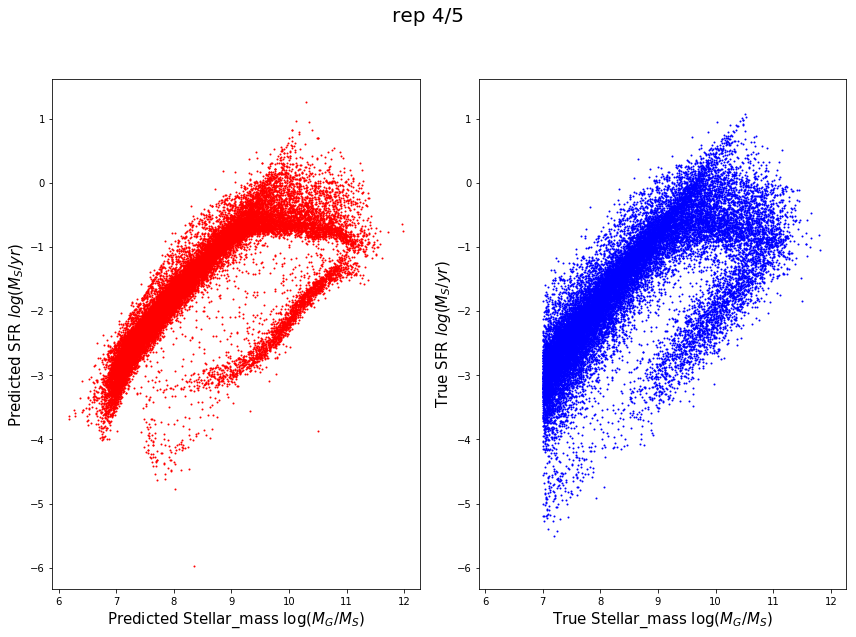

Train on 10000 samples, validate on 25000 samples
Epoch 1/1000
10000/10000 [==============================] - 0s 18us/step - loss: 1.2721e-05 - Stellar_mass_loss: 9.0259e-07 - SFR_loss: 1.1818e-05 - val_loss: 5.9991e-06 - val_Stellar_mass_loss: 5.8192e-07 - val_SFR_loss: 5.4172e-06
Epoch 2/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2749e-05 - Stellar_mass_loss: 9.3957e-07 - SFR_loss: 1.1809e-05 - val_loss: 5.9440e-06 - val_Stellar_mass_loss: 5.3621e-07 - val_SFR_loss: 5.4078e-06
Epoch 3/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2553e-05 - Stellar_mass_loss: 8.0368e-07 - SFR_loss: 1.1750e-05 - val_loss: 6.0026e-06 - val_Stellar_mass_loss: 5.4562e-07 - val_SFR_loss: 5.4570e-06
Epoch 4/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2530e-05 - Stellar_mass_loss: 7.5894e-07 - SFR_loss: 1.1771e-05 - val_loss: 5.9263e-06 - val_Stellar_mass_loss: 5.4163e-07 - val_SFR_loss: 5.3846e-06
Epoch 5/1000
10000

Epoch 36/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2526e-05 - Stellar_mass_loss: 7.2879e-07 - SFR_loss: 1.1797e-05 - val_loss: 6.0511e-06 - val_Stellar_mass_loss: 5.6953e-07 - val_SFR_loss: 5.4816e-06
Epoch 37/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2517e-05 - Stellar_mass_loss: 7.0821e-07 - SFR_loss: 1.1809e-05 - val_loss: 6.0122e-06 - val_Stellar_mass_loss: 5.8411e-07 - val_SFR_loss: 5.4281e-06
Epoch 38/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2505e-05 - Stellar_mass_loss: 7.2756e-07 - SFR_loss: 1.1777e-05 - val_loss: 6.0444e-06 - val_Stellar_mass_loss: 5.6801e-07 - val_SFR_loss: 5.4764e-06
Epoch 39/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2581e-05 - Stellar_mass_loss: 7.7249e-07 - SFR_loss: 1.1809e-05 - val_loss: 6.0454e-06 - val_Stellar_mass_loss: 5.5662e-07 - val_SFR_loss: 5.4888e-06
Epoch 40/1000
10000/10000 [==============================] - 0s 

10000/10000 [==============================] - 0s 20us/step - loss: 1.2602e-05 - Stellar_mass_loss: 9.7634e-07 - SFR_loss: 1.1626e-05 - val_loss: 5.8554e-06 - val_Stellar_mass_loss: 4.4718e-07 - val_SFR_loss: 5.4083e-06
Epoch 72/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2718e-05 - Stellar_mass_loss: 9.1034e-07 - SFR_loss: 1.1808e-05 - val_loss: 5.8721e-06 - val_Stellar_mass_loss: 4.6511e-07 - val_SFR_loss: 5.4070e-06
Epoch 73/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2655e-05 - Stellar_mass_loss: 9.4097e-07 - SFR_loss: 1.1714e-05 - val_loss: 5.8445e-06 - val_Stellar_mass_loss: 4.6304e-07 - val_SFR_loss: 5.3815e-06
Epoch 74/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2548e-05 - Stellar_mass_loss: 8.9792e-07 - SFR_loss: 1.1650e-05 - val_loss: 5.8566e-06 - val_Stellar_mass_loss: 4.7842e-07 - val_SFR_loss: 5.3782e-06
Epoch 75/1000
10000/10000 [==============================] - 0s 21us/step - lo

10000/10000 [==============================] - 0s 20us/step - loss: 1.2419e-05 - Stellar_mass_loss: 8.0126e-07 - SFR_loss: 1.1618e-05 - val_loss: 5.9461e-06 - val_Stellar_mass_loss: 5.5040e-07 - val_SFR_loss: 5.3957e-06
Epoch 107/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2777e-05 - Stellar_mass_loss: 8.2614e-07 - SFR_loss: 1.1951e-05 - val_loss: 6.1633e-06 - val_Stellar_mass_loss: 5.9882e-07 - val_SFR_loss: 5.5645e-06
Epoch 108/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2483e-05 - Stellar_mass_loss: 7.4963e-07 - SFR_loss: 1.1733e-05 - val_loss: 5.9392e-06 - val_Stellar_mass_loss: 5.7645e-07 - val_SFR_loss: 5.3627e-06
Epoch 109/1000
10000/10000 [==============================] - 0s 19us/step - loss: 1.2487e-05 - Stellar_mass_loss: 7.9570e-07 - SFR_loss: 1.1691e-05 - val_loss: 5.9332e-06 - val_Stellar_mass_loss: 5.5190e-07 - val_SFR_loss: 5.3813e-06
Epoch 110/1000
10000/10000 [==============================] - 0s 19us/step 

Epoch 141/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2405e-05 - Stellar_mass_loss: 7.8948e-07 - SFR_loss: 1.1615e-05 - val_loss: 5.9810e-06 - val_Stellar_mass_loss: 6.2490e-07 - val_SFR_loss: 5.3561e-06
Epoch 142/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2398e-05 - Stellar_mass_loss: 8.3191e-07 - SFR_loss: 1.1566e-05 - val_loss: 5.9444e-06 - val_Stellar_mass_loss: 5.4909e-07 - val_SFR_loss: 5.3953e-06
Epoch 143/1000
10000/10000 [==============================] - 0s 21us/step - loss: 1.2296e-05 - Stellar_mass_loss: 7.2175e-07 - SFR_loss: 1.1574e-05 - val_loss: 5.8937e-06 - val_Stellar_mass_loss: 5.3495e-07 - val_SFR_loss: 5.3587e-06
Epoch 144/1000
10000/10000 [==============================] - 0s 20us/step - loss: 1.2489e-05 - Stellar_mass_loss: 9.5003e-07 - SFR_loss: 1.1539e-05 - val_loss: 5.9500e-06 - val_Stellar_mass_loss: 5.6198e-07 - val_SFR_loss: 5.3880e-06
Epoch 145/1000
10000/10000 [==============================] 

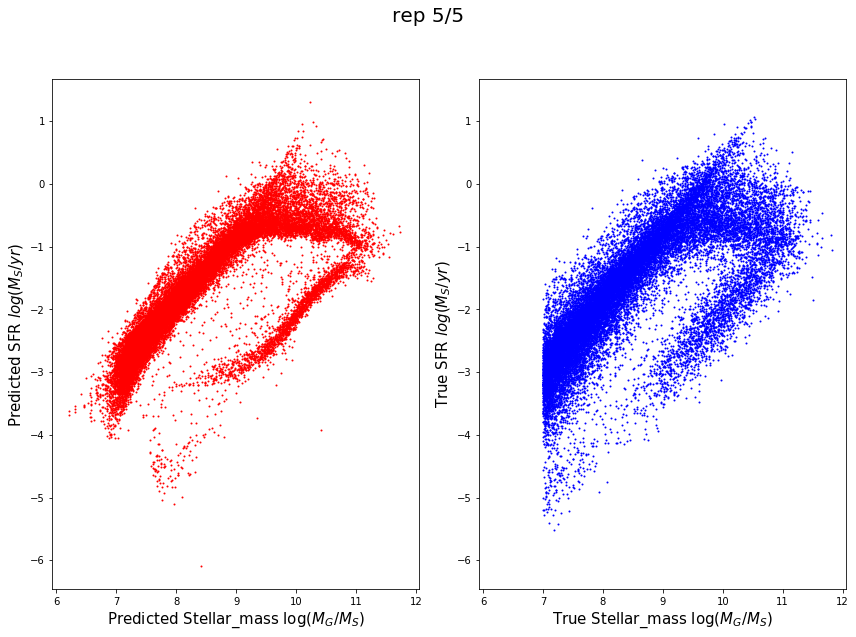

In [8]:
for i_rep in range(1, nr_repetitions+1):
    
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], val_weights), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=train_weights, verbose=1)
    fig = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
                                    y_axis_feature = 'SFR', title='rep %d/%d'%(i_rep,nr_repetitions), y_max = None, 
                                    y_min = None,
                                    x_min = None, x_max = None, data_type='val')
    plt.show()

In [ ]:
model = Model(main_input, output_layers)
model.compile(optimizer = 'adam', loss = 'mse')

#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search

In [3]:
nr_folds = 1
#total_set_size = int(1e4 + 1/(nr_folds-1)*1e4)
total_set_size = 3.5e4
train_size = 1e4
val_size = 2.5e4
test_size = 0

input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']

nr_layers = [3, 8, 20]
neurons_per_layer = [3, 10, 30]
activation_functions = ['leaky_relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std', 'zero_to_one']
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e3]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = 200
early_stop_min_delta = 1e-20

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing four objects. The first one is ' + \
    'the parameters of the model. The second one is a list with 1: the mean best val score obtained based on the '+\
    'k folds, 2: the std for these scoresl and 3: the best validation score from all folds and histories.' +\
    'The third one is the training' +\
    'loss histories for the different folds and the fourth one is the validation loss histories on the different folds.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds
run_counter = 0 # to keep track of how many combinations I've gone through

earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            for i_inp_norm, inp_norm in enumerate(input_norms):
                norm = {'input': inp_norm,
                        'output': 'none'}
                for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                    for i_nr_lay, nr_lay in enumerate(nr_layers):
                        for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                        
                            train_histories = []
                            val_histories = []
                            scores = []
                            
                            for fold in range(nr_folds):
                                
                                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                                run_counter += 1
                                f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                                f.flush()

                                # prepare the training data
                                training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                                                       output_features, int(total_set_size), 
                                                                       train_size=int(train_size), 
                                                                       val_size=int(val_size), test_size=int(test_size))
                                                   #  divide_train_data(galaxies, data_keys, input_features, 
                                                   #                    output_features, total_set_size, k_fold_cv=True, 
                                                   #                    tot_cv_folds=nr_folds, cv_fold_nr=fold)
                                training_data_dict = normalise_data(training_data_dict, norm)
                                
                                # set data point weights
                                train_weights, val_weights = get_weights(training_data_dict, output_features, 
                                                                         outputs_to_weigh)
                                
                                # Create model
                                main_input = Input(shape=(len(input_features),), name = 'main_input')
                                
                                if act_fun == 'leaky_relu':
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x1 = LeakyReLU(alpha = 0.1)(x1)
                                    x2 = LeakyReLU(alpha = 0.1)(x2)
                                else:
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    
                                for i in range(0, nr_lay-1): # -1 because one is added automatically
                                    if act_fun == 'leaky_relu':
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x2)
                                        x1 = LeakyReLU(alpha = 0.1)(x1)
                                        x2 = LeakyReLU(alpha = 0.1)(x2)
                                        
                                    else:
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x2)

                                output_layers = []
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'Stellar_mass',
                                                           activation = output_activation['Stellar_mass'])(x1))
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'SFR',
                                                           activation = output_activation['SFR'])(x2))

                                model = Model(main_input, output_layers)
                                model.compile(optimizer = 'adam', loss = loss_function)

                                # Fit the model
                                history = model.fit(x = training_data_dict['input_train_dict'], 
                                                    y = training_data_dict['output_train_dict'], 
                                                    validation_data = (training_data_dict['input_val_dict'], 
                                                    training_data_dict['output_val_dict'], val_weights), 
                                                    epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), 
                                                    callbacks=callbacks_list, sample_weight=train_weights, verbose=verb)

                                train_histories.append(history.history['loss'])
                                val_histories.append(history.history['val_loss'])
                                scores.append(np.amin(history.history['val_loss']))
                                
                            best_score = np.amin(scores)
                            mean_score = np.mean(scores)
                            score_std = np.std(scores)
                            total_score = [mean_score, score_std, best_score]
                            parameters = {'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                            results_list.append([parameters, total_score, train_histories, val_histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

Epoch 01816: early stopping
Epoch 01493: early stopping
Epoch 04397: early stopping
Epoch 02491: early stopping
Epoch 01369: early stopping
Epoch 02697: early stopping
Epoch 00273: early stopping
Epoch 01009: early stopping
Epoch 01301: early stopping
Epoch 00377: early stopping
Epoch 00459: early stopping
Epoch 00598: early stopping
Epoch 04690: early stopping
Epoch 01751: early stopping
Epoch 02461: early stopping
Epoch 02414: early stopping
Epoch 02749: early stopping
Epoch 00680: early stopping
Epoch 01465: early stopping
Epoch 01606: early stopping
Epoch 02291: early stopping
Epoch 01858: early stopping
Epoch 04653: early stopping
Epoch 00357: early stopping
Epoch 00715: early stopping
Epoch 00921: early stopping
Epoch 00229: early stopping
Epoch 00516: early stopping
Epoch 00717: early stopping
Epoch 01192: early stopping
Epoch 02593: early stopping
Epoch 00337: early stopping
Epoch 00688: early stopping
Epoch 01319: early stopping
Epoch 04105: early stopping


KeyboardInterrupt: 

In [ ]:
print(results_list[1][2])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
for comb_nr, lst in enumerate(results_list[1:]):

    title = str(lst[0]) + '\n mean final validation score: {:.2e}$\pm${:.2e}'.format(lst[1][0], lst[1][1])
    train_losses = lst[2]
    val_losses = lst[3]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for train_loss, val_loss in zip(train_losses, val_losses):
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(list(history.history.keys()))

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('hyperparameter_searches/' + date_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Old code

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)